# NN_Polar_Decoder

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%matplotlib inline
import gc
gc.collect(generation=2)

4

### Define Noise & Modulator

In [2]:
def BPSK_modulator(x):
    return -2*x +1

In [3]:
def qpsk_NRZ_encoder(x):
    half_CWs = int(x.shape[1]/2)    # half codewords length
    for i in range(x.shape[0]):     # batch_size
        for j in range(half_CWs):
            if (x[i,j] == x[i,j+half_CWs]):  # 00 & 11 -> -2*x +1
                x[i,j] = (-2*x[i,j]) +1
                x[i,j+half_CWs] = (-2*x[i,j+half_CWs]) +1      
            if (x[i,j] != x[i,j+half_CWs]):  # 01 & 10 -> 2*x -1
                x[i,j] = (2*x[i,j]) -1
                x[i,j+half_CWs] = (2*x[i,j+half_CWs]) -1     
    return x/np.sqrt(2)

In [4]:
def QPSK_modulator(x):
    # X = after polar encoding (256,16)
    # QPSK step : 
    # First : 把實部虛部分開，並把虛部丟在實部後面
    real = []
    imag = []
    stack = []
    for n in range(x.shape[0]):  # batch-size
        for m in range(0, x.shape[1], 2): 
            stack.append(x[n,m])  # real-part
        real.append(stack)
        stack = []
        for m in range(1, x.shape[1], 2): 
            stack.append(x[n,m])  # imag-part
        imag.append(stack)
        stack = []
    symbol_np = np.hstack((real, imag))
    # Second : NRZ-encoding (0 -> +1 ; 1 -> -1)
    # symbol_nrz = (-2*symbol_np +1)/np.sqrt(2)
    symbol_nrz = qpsk_NRZ_encoder(symbol_np)
    return symbol_nrz

In [5]:
def AWGN_addNoise(x, awgn_power):
    sym_num = int(x.shape[1]/2)
    y = np.zeros((x.shape[0],x.shape[1]))
    for i in range (x.shape[0]):       # batch-size
        for j in range (sym_num):      # no_of_bits
            y[i,j] = x[i,j] + np.sqrt(awgn_power/2) * np.random.normal(0,1)                   # real-part
            y[i,j+sym_num] = x[i,j+sym_num] + np.sqrt(awgn_power/2) * np.random.normal(0,1)   # imag-part
    return y

In [6]:
def FineTuning_addNoise(x, awgn_power):
    sym_num = int(x.shape[1]/2)
    y = np.zeros((x.shape[0],x.shape[1]))
    for i in range (x.shape[0]):       # batch-size
        real_add_impulse = np.random.randint(low=0, high=sym_num)
        for j in range (sym_num):      # no_of_bits
            if (j == real_add_impulse) :
                IGR = 100              # 高斯脈衝能量比
                impulse_power = awgn_power * IGR
                y[i,j] = x[i,j] + np.sqrt(impulse_power/2) * np.random.normal(0,1)                  # real-part
                y[i,j+sym_num] = x[i,j+sym_num] + np.sqrt(impulse_power/2) * np.random.normal(0,1)  # imag-part
            else : 
                y[i,j] = x[i,j] + np.sqrt(awgn_power/2) * np.random.normal(0,1)                     # real-part
                y[i,j+sym_num] = x[i,j+sym_num] + np.sqrt(awgn_power/2) * np.random.normal(0,1)     # imag-part
    return y

In [7]:
def Test_addNoise(x, awgn_power, impulse_prob):
    sym_num = int(x.shape[1]/2)
    y = np.zeros((x.shape[0],x.shape[1]))
    for i in range (x.shape[0]):       # batch-size
        for j in range (sym_num):      # no_of_bits
            dice = np.random.uniform(0,1)   # 0~1 隨機選一個小數
            if (dice <= impulse_prob) :
                IGR = 100                # 高斯脈衝能量比
                impulse_power = awgn_power * IGR
                y[i,j] = x[i,j] + np.sqrt(impulse_power/2) * np.random.normal(0,1)           # real-part
                y[i,j+sym_num] = x[i,j+sym_num] + np.sqrt(impulse_power/2) * np.random.normal(0,1)   # imag-part
            else : 
                y[i,j] = x[i,j] + np.sqrt(awgn_power/2) * np.random.normal(0,1)              # real-part
                y[i,j+sym_num] = x[i,j+sym_num] + np.sqrt(awgn_power/2) * np.random.normal(0,1)      # imag-part
    return y

### Polar Encoder (Bhattacharyya)

In [8]:
"""
    Algorithm : The Bhattacharyya bounds
"""
def polarization_channel_awgn(N, k, design_snr_dB=0):  
    design_snr_dB = design_snr_dB +10*np.log10(k/N)
    S = 10**(design_snr_dB/10)       # S : R*Eb/N0
    n = np.log2(N)                   # N = 2^n
    z0 = np.zeros(N)                 # N : Codewords length
    # initial the Bhattacharyya parameter of BI-AWGN channel,be replaced with exp(−R*Eb/N0)
    z0[0] = np.exp(-S)               # initial erasure-probability of channel        
    for j in range(1,int(n)+1):      # How many stage to polarization (output-to-input)
        u = 2**j                     # 2^n = N = 幾個 W 副本通道
        for t in range(0,int(u/2)):  # For each connection
            T = z0[t]
            z0[t] = 2*T - T**2       # upper channel (+ channel)
            z0[int(u/2)+t] = T**2    # lower channel (- channel)
    # sort into increasing order
    # z0 array 裝的是每個分離通道的 Prob.Error 數值，
    # 數值越大代表通道越糟
    #====> 通道由最好排到最差 (左[0]->右[N]) <====#
    idx = np.argsort(z0)             
    # argsort() 返回的是數組值從小到大的索引值
    #====> 通道由最好排到最差 (左[0]->右[N]) <====#
    # select k best channels
    # 選最好的前半部分通道做 bit-reversal
    ######### idx = np.sort(bitrevorder(idx[0:k]))
    A = np.zeros(N, dtype=bool)
    A[idx[0:k]] = True   # 將 Good_channel 設為可傳 info.
    # idx 為 " 好的通道 " bit-reversal 後的新通道
    return A

def polar_xor_encoding(u):  
    # 每一組 codewords 為 16-bits , 共 256 組
    N = len(u)   # 只看第一維 N = 2**k
    n = 1
    x = np.copy(u)
    stages = np.log2(N).astype(int)   # 通道共分裂成幾階
    for s in range(0,stages):         # s = stage
        i = 0                         # i = no.of samples
        while i < N:                  # N = 256            
            for j in range(0,n):      # j always = 0
                idx = i+j
                x[idx] = x[idx] ^ x[idx+n]  # XOR : Good Channel
            i=i+2*n
        n=2*n
    return x

### Build Torch NN Training Model

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [10]:
k = 11                        # number of information bits
N = 64                        # code length (After Encoder data size)  
R = k/N

In [11]:
class DNN_Model(nn.Module):
    def __init__(self):
        super(DNN_Model, self).__init__()
        self.fcnn1 = nn.Linear(N, 1500)                  # 第1層 Linear NN
        self.fcnn2 = nn.Linear(1500, 1500)                # 第2層 Linear NN
        self.fcnn3 = nn.Linear(1500, 1200)                 # 第3層 Linear NN
        self.fcnn4 = nn.Linear(1200, 1000)                 # 第3層 Linear NN
        self.output = nn.Linear(1000, k)                  # 第4層 Linear NN
        # nn.init.kaiming_normal_(self.fcnn2.weight, mode='fan_in')     
        # nn.init.normal_(self.fcnn4.bias, mean=0.0, std=0.1)

    def forward(self, input_layer):
        x = F.relu(self.fcnn1(input_layer))
        x = F.relu(self.fcnn2(x))
        x = F.relu(self.fcnn3(x))
        x = F.relu(self.fcnn4(x))
        predi_output = torch.sigmoid(self.output(x))
        return predi_output
        
decoder = DNN_Model()                      # build the DNN Model
print("**decoder_model:",decoder)          # 將模型print

**decoder_model: DNN_Model(
  (fcnn1): Linear(in_features=64, out_features=1500, bias=True)
  (fcnn2): Linear(in_features=1500, out_features=1500, bias=True)
  (fcnn3): Linear(in_features=1500, out_features=1200, bias=True)
  (fcnn4): Linear(in_features=1200, out_features=1000, bias=True)
  (output): Linear(in_features=1000, out_features=11, bias=True)
)


### Loss Function Tensor to String Transfer

In [12]:
import numpy as np
import re

In [13]:
err_tensor_str = ""

In [14]:
err_num = re.findall(r"\d+\.?\d*",err_tensor_str)
float_err_num = list(map(float, err_num))
clip_0 = []
# print(float_err_num)
for i in range(0, len(float_err_num), 2):
    clip_0.append(float_err_num[i])
print(clip_0)

[]


### Plot Loss Function

In [15]:
# n = np.linspace(0, 2001, 1804)

In [16]:
"""
# No Smoothing :
total_hist_loss = awgn_1 + awgn_2 + impulse_1 + impulse_2
plt.plot(total_hist_loss)
plt.title('Model loss', fontsize=17)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['Fine-Tuning Training-Loss'], fontsize=15)
plt.grid(True, which="both")
plt.rcParams['figure.figsize'] = (9, 6)
plt.show()
"""

'\n# No Smoothing :\ntotal_hist_loss = awgn_1 + awgn_2 + impulse_1 + impulse_2\nplt.plot(total_hist_loss)\nplt.title(\'Model loss\', fontsize=17)\nplt.ylabel(\'Loss\', fontsize=15)\nplt.xlabel(\'Epoch\', fontsize=15)\nplt.legend([\'Fine-Tuning Training-Loss\'], fontsize=15)\nplt.grid(True, which="both")\nplt.rcParams[\'figure.figsize\'] = (9, 6)\nplt.show()\n'

In [17]:
"""
def smooth_curve(points, factor=0.995):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
"""

'\ndef smooth_curve(points, factor=0.995):\n    smoothed_points = []\n    for point in points:\n        if smoothed_points:\n            previous = smoothed_points[-1]\n            smoothed_points.append(previous * factor + point * (1 - factor))\n        else:\n            smoothed_points.append(point)\n    return smoothed_points\n'

In [18]:
"""
# when plotting, smooth out the points by some factor (0.5 = rough, 0.99 = smooth)
np_hist = np.array(total_hist_loss)
loss = smooth_curve(np_hist)
plt.plot(loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.grid(True, which="both")
plt.show()
"""

'\n# when plotting, smooth out the points by some factor (0.5 = rough, 0.99 = smooth)\nnp_hist = np.array(total_hist_loss)\nloss = smooth_curve(np_hist)\nplt.plot(loss)\nplt.title(\'Model loss\')\nplt.ylabel(\'Loss\')\nplt.xlabel(\'Epoch\')\nplt.legend([\'Train\', \'Test\'])\nplt.grid(True, which="both")\nplt.show()\n'

### Test NN Decoder

In [19]:
## load model weights
decoder.load_state_dict(torch.load('Prob-003_FT-V9_4-dB.pt'))
decoder.eval()

DNN_Model(
  (fcnn1): Linear(in_features=64, out_features=1500, bias=True)
  (fcnn2): Linear(in_features=1500, out_features=1500, bias=True)
  (fcnn3): Linear(in_features=1500, out_features=1200, bias=True)
  (fcnn4): Linear(in_features=1200, out_features=1000, bias=True)
  (output): Linear(in_features=1000, out_features=11, bias=True)
)

In [20]:
k = 11                        # number of information bits
N = 64                        # code length (After Encoder data size)  
R = k/N
num_words = 1000              # multiple of test_batch
test_batch = 1 

In [21]:
# define test SNR & noise power
test_SNR_dB = np.array([0, 1, 2, 3, 4, 5])
test_noise_power = 1/10**(test_SNR_dB/10) 
test_noise_power = test_noise_power * 2
print("test_noise_power:", test_noise_power)    # 1/2*No
print("test_noise_sigma:", np.sqrt(test_noise_power/2))

test_noise_power: [2.         1.58865647 1.26191469 1.00237447 0.79621434 0.63245553]
test_noise_sigma: [1.         0.89125094 0.79432823 0.70794578 0.63095734 0.56234133]


In [22]:
# Polar Code Channel Polarization
A = polarization_channel_awgn(N, k, design_snr_dB = 0)  

In [23]:
impulse_probs = [0.001, 0.01, 0.03]   # 2/64 = 0.03
print("**impulse_probs:",impulse_probs,"**")
nb_errors = np.zeros((len(impulse_probs),len(test_noise_power)))
nb_bits = np.zeros((len(impulse_probs),len(test_noise_power)))
#sigma_with_impulse_table = np.zeros((len(impulse_probs),len(sigmas)))
print("-------------------------------------------------------------------------------------------")

for s in range(0,len(test_noise_power)):   # SNR_dB
    for p in range(0,len(impulse_probs)):  # impulse_prob   
        print("================= AWGN_SNR:",test_SNR_dB[s]," dB, (with impulse_prob=",impulse_probs[p],") =================")
        wrong_bits = 0
        Error_counter = 0
        while (nb_errors[p,s] <= 5500 and Error_counter <= 1100):  # Error control Threshold
            Error_counter = Error_counter +1
            print("# Error_counter:", Error_counter)
            for ii in range(1, np.round(num_words/test_batch).astype(int)+1):  # each batchs
                # print("**No_of_batch:",ii,"**")
                ## np.round ()平均舍入到給定的小數位數 = 四捨五入取整數。
                ## Source (only information-bits)
                d_test_info = np.random.binomial(n=1, p=0.5, size=(test_batch, k))
                ## d_test_info = np.random.randint(0, 2, size=(test_batch, k))
            #======================================= Polar Encoder ===========================================#
                x_test = np.zeros((test_batch, N),dtype=bool)
                u_test = np.zeros((test_batch, N),dtype=bool)
                u_test[:,A] = d_test_info
                for iii in range(0,test_batch):
                    x_test[iii] = polar_xor_encoding(u_test[iii])
                x_test = x_test.astype(int)
            #========================================== Modulator ============================================#
                ## m_test = -2*x_test +1                  # Modulator (BPSK)
                m_test = QPSK_modulator(x_test)          # Modulator (QPSK)
            #================================= Channel (AWGN + Impulse) ======================================#
                y_test = Test_addNoise(x=m_test, awgn_power=test_noise_power[s], impulse_prob=impulse_probs[p])
                ## y_test = FineTuning_addNoise(x=m_test, awgn_power=test_noise_power[s])
                ## y_test = AWGN_addNoise(x=m_test, awgn_power=test_noise_power[s])
            #==================================== Decoder predict output =====================================#
                predi_out = decoder(torch.tensor(y_test).float())
                predi_out = predi_out.detach().numpy()
                pred_desicion = np.round(predi_out)
                # print("**pred_desicion:", pred_desicion)
                # print("**d_test_info  :", d_test_info)
                wrong_bits = np.sum(np.not_equal(pred_desicion, d_test_info))
                # print("**Word_wrong_bits:", wrong_bits)
                nb_errors[p,s] += wrong_bits
                # print("**Cumulative_error_bits:", nb_errors[p,s])
                nb_bits[p,s] += d_test_info.size
                # print("**Cumulative_total_bits:", nb_bits[p,s], "**")
                # print("--------------------------------------------------------------------------")
                if (nb_errors[p,s] > 5500): break   # if batch_sum_errors > 5500 : leave loop
            print("**Cumulative_error_bits:", nb_errors[p,s])
            print("**Cumulative_total_bits:", nb_bits[p,s], "**")
            print("--------------------------------------------------------------------------")
            gc.collect(generation=2)
            continue   # if error bits not enough: keep decoding

**impulse_probs: [0.001, 0.01, 0.03] **
-------------------------------------------------------------------------------------------
================= AWGN_SNR: 0  dB, (with impulse_prob= 0.001 ) =================
# Error_counter: 1
**Cumulative_error_bits: 508.0
**Cumulative_total_bits: 11000.0 **
--------------------------------------------------------------------------
# Error_counter: 2
**Cumulative_error_bits: 959.0
**Cumulative_total_bits: 22000.0 **
--------------------------------------------------------------------------
# Error_counter: 3
**Cumulative_error_bits: 1412.0
**Cumulative_total_bits: 33000.0 **
--------------------------------------------------------------------------
# Error_counter: 4
**Cumulative_error_bits: 1890.0
**Cumulative_total_bits: 44000.0 **
--------------------------------------------------------------------------
# Error_counter: 5
**Cumulative_error_bits: 2448.0
**Cumulative_total_bits: 55000.0 **
------------------------------------------------------

**Cumulative_error_bits: 4037.0
**Cumulative_total_bits: 220000.0 **
--------------------------------------------------------------------------
# Error_counter: 21
**Cumulative_error_bits: 4247.0
**Cumulative_total_bits: 231000.0 **
--------------------------------------------------------------------------
# Error_counter: 22
**Cumulative_error_bits: 4412.0
**Cumulative_total_bits: 242000.0 **
--------------------------------------------------------------------------
# Error_counter: 23
**Cumulative_error_bits: 4626.0
**Cumulative_total_bits: 253000.0 **
--------------------------------------------------------------------------
# Error_counter: 24
**Cumulative_error_bits: 4849.0
**Cumulative_total_bits: 264000.0 **
--------------------------------------------------------------------------
# Error_counter: 25
**Cumulative_error_bits: 5048.0
**Cumulative_total_bits: 275000.0 **
--------------------------------------------------------------------------
# Error_counter: 26
**Cumulative_err

**Cumulative_error_bits: 286.0
**Cumulative_total_bits: 55000.0 **
--------------------------------------------------------------------------
# Error_counter: 6
**Cumulative_error_bits: 327.0
**Cumulative_total_bits: 66000.0 **
--------------------------------------------------------------------------
# Error_counter: 7
**Cumulative_error_bits: 398.0
**Cumulative_total_bits: 77000.0 **
--------------------------------------------------------------------------
# Error_counter: 8
**Cumulative_error_bits: 467.0
**Cumulative_total_bits: 88000.0 **
--------------------------------------------------------------------------
# Error_counter: 9
**Cumulative_error_bits: 522.0
**Cumulative_total_bits: 99000.0 **
--------------------------------------------------------------------------
# Error_counter: 10
**Cumulative_error_bits: 569.0
**Cumulative_total_bits: 110000.0 **
--------------------------------------------------------------------------
# Error_counter: 11
**Cumulative_error_bits: 629.0


**Cumulative_error_bits: 3357.0
**Cumulative_total_bits: 616000.0 **
--------------------------------------------------------------------------
# Error_counter: 57
**Cumulative_error_bits: 3421.0
**Cumulative_total_bits: 627000.0 **
--------------------------------------------------------------------------
# Error_counter: 58
**Cumulative_error_bits: 3481.0
**Cumulative_total_bits: 638000.0 **
--------------------------------------------------------------------------
# Error_counter: 59
**Cumulative_error_bits: 3506.0
**Cumulative_total_bits: 649000.0 **
--------------------------------------------------------------------------
# Error_counter: 60
**Cumulative_error_bits: 3554.0
**Cumulative_total_bits: 660000.0 **
--------------------------------------------------------------------------
# Error_counter: 61
**Cumulative_error_bits: 3629.0
**Cumulative_total_bits: 671000.0 **
--------------------------------------------------------------------------
# Error_counter: 62
**Cumulative_err

**Cumulative_error_bits: 1274.0
**Cumulative_total_bits: 154000.0 **
--------------------------------------------------------------------------
# Error_counter: 15
**Cumulative_error_bits: 1361.0
**Cumulative_total_bits: 165000.0 **
--------------------------------------------------------------------------
# Error_counter: 16
**Cumulative_error_bits: 1423.0
**Cumulative_total_bits: 176000.0 **
--------------------------------------------------------------------------
# Error_counter: 17
**Cumulative_error_bits: 1518.0
**Cumulative_total_bits: 187000.0 **
--------------------------------------------------------------------------
# Error_counter: 18
**Cumulative_error_bits: 1591.0
**Cumulative_total_bits: 198000.0 **
--------------------------------------------------------------------------
# Error_counter: 19
**Cumulative_error_bits: 1685.0
**Cumulative_total_bits: 209000.0 **
--------------------------------------------------------------------------
# Error_counter: 20
**Cumulative_err

**Cumulative_error_bits: 801.0
**Cumulative_total_bits: 44000.0 **
--------------------------------------------------------------------------
# Error_counter: 5
**Cumulative_error_bits: 1009.0
**Cumulative_total_bits: 55000.0 **
--------------------------------------------------------------------------
# Error_counter: 6
**Cumulative_error_bits: 1192.0
**Cumulative_total_bits: 66000.0 **
--------------------------------------------------------------------------
# Error_counter: 7
**Cumulative_error_bits: 1397.0
**Cumulative_total_bits: 77000.0 **
--------------------------------------------------------------------------
# Error_counter: 8
**Cumulative_error_bits: 1597.0
**Cumulative_total_bits: 88000.0 **
--------------------------------------------------------------------------
# Error_counter: 9
**Cumulative_error_bits: 1766.0
**Cumulative_total_bits: 99000.0 **
--------------------------------------------------------------------------
# Error_counter: 10
**Cumulative_error_bits: 201

**Cumulative_error_bits: 391.0
**Cumulative_total_bits: 286000.0 **
--------------------------------------------------------------------------
# Error_counter: 27
**Cumulative_error_bits: 409.0
**Cumulative_total_bits: 297000.0 **
--------------------------------------------------------------------------
# Error_counter: 28
**Cumulative_error_bits: 423.0
**Cumulative_total_bits: 308000.0 **
--------------------------------------------------------------------------
# Error_counter: 29
**Cumulative_error_bits: 439.0
**Cumulative_total_bits: 319000.0 **
--------------------------------------------------------------------------
# Error_counter: 30
**Cumulative_error_bits: 465.0
**Cumulative_total_bits: 330000.0 **
--------------------------------------------------------------------------
# Error_counter: 31
**Cumulative_error_bits: 476.0
**Cumulative_total_bits: 341000.0 **
--------------------------------------------------------------------------
# Error_counter: 32
**Cumulative_error_bit

**Cumulative_error_bits: 1095.0
**Cumulative_total_bits: 847000.0 **
--------------------------------------------------------------------------
# Error_counter: 78
**Cumulative_error_bits: 1103.0
**Cumulative_total_bits: 858000.0 **
--------------------------------------------------------------------------
# Error_counter: 79
**Cumulative_error_bits: 1109.0
**Cumulative_total_bits: 869000.0 **
--------------------------------------------------------------------------
# Error_counter: 80
**Cumulative_error_bits: 1116.0
**Cumulative_total_bits: 880000.0 **
--------------------------------------------------------------------------
# Error_counter: 81
**Cumulative_error_bits: 1128.0
**Cumulative_total_bits: 891000.0 **
--------------------------------------------------------------------------
# Error_counter: 82
**Cumulative_error_bits: 1137.0
**Cumulative_total_bits: 902000.0 **
--------------------------------------------------------------------------
# Error_counter: 83
**Cumulative_err

**Cumulative_error_bits: 1696.0
**Cumulative_total_bits: 1397000.0 **
--------------------------------------------------------------------------
# Error_counter: 128
**Cumulative_error_bits: 1707.0
**Cumulative_total_bits: 1408000.0 **
--------------------------------------------------------------------------
# Error_counter: 129
**Cumulative_error_bits: 1709.0
**Cumulative_total_bits: 1419000.0 **
--------------------------------------------------------------------------
# Error_counter: 130
**Cumulative_error_bits: 1731.0
**Cumulative_total_bits: 1430000.0 **
--------------------------------------------------------------------------
# Error_counter: 131
**Cumulative_error_bits: 1738.0
**Cumulative_total_bits: 1441000.0 **
--------------------------------------------------------------------------
# Error_counter: 132
**Cumulative_error_bits: 1752.0
**Cumulative_total_bits: 1452000.0 **
--------------------------------------------------------------------------
# Error_counter: 133
**Cu

**Cumulative_error_bits: 2270.0
**Cumulative_total_bits: 1947000.0 **
--------------------------------------------------------------------------
# Error_counter: 178
**Cumulative_error_bits: 2281.0
**Cumulative_total_bits: 1958000.0 **
--------------------------------------------------------------------------
# Error_counter: 179
**Cumulative_error_bits: 2293.0
**Cumulative_total_bits: 1969000.0 **
--------------------------------------------------------------------------
# Error_counter: 180
**Cumulative_error_bits: 2297.0
**Cumulative_total_bits: 1980000.0 **
--------------------------------------------------------------------------
# Error_counter: 181
**Cumulative_error_bits: 2310.0
**Cumulative_total_bits: 1991000.0 **
--------------------------------------------------------------------------
# Error_counter: 182
**Cumulative_error_bits: 2332.0
**Cumulative_total_bits: 2002000.0 **
--------------------------------------------------------------------------
# Error_counter: 183
**Cu

**Cumulative_error_bits: 2830.0
**Cumulative_total_bits: 2497000.0 **
--------------------------------------------------------------------------
# Error_counter: 228
**Cumulative_error_bits: 2842.0
**Cumulative_total_bits: 2508000.0 **
--------------------------------------------------------------------------
# Error_counter: 229
**Cumulative_error_bits: 2846.0
**Cumulative_total_bits: 2519000.0 **
--------------------------------------------------------------------------
# Error_counter: 230
**Cumulative_error_bits: 2861.0
**Cumulative_total_bits: 2530000.0 **
--------------------------------------------------------------------------
# Error_counter: 231
**Cumulative_error_bits: 2872.0
**Cumulative_total_bits: 2541000.0 **
--------------------------------------------------------------------------
# Error_counter: 232
**Cumulative_error_bits: 2889.0
**Cumulative_total_bits: 2552000.0 **
--------------------------------------------------------------------------
# Error_counter: 233
**Cu

**Cumulative_error_bits: 3478.0
**Cumulative_total_bits: 3047000.0 **
--------------------------------------------------------------------------
# Error_counter: 278
**Cumulative_error_bits: 3497.0
**Cumulative_total_bits: 3058000.0 **
--------------------------------------------------------------------------
# Error_counter: 279
**Cumulative_error_bits: 3511.0
**Cumulative_total_bits: 3069000.0 **
--------------------------------------------------------------------------
# Error_counter: 280
**Cumulative_error_bits: 3514.0
**Cumulative_total_bits: 3080000.0 **
--------------------------------------------------------------------------
# Error_counter: 281
**Cumulative_error_bits: 3536.0
**Cumulative_total_bits: 3091000.0 **
--------------------------------------------------------------------------
# Error_counter: 282
**Cumulative_error_bits: 3543.0
**Cumulative_total_bits: 3102000.0 **
--------------------------------------------------------------------------
# Error_counter: 283
**Cu

**Cumulative_error_bits: 4155.0
**Cumulative_total_bits: 3597000.0 **
--------------------------------------------------------------------------
# Error_counter: 328
**Cumulative_error_bits: 4173.0
**Cumulative_total_bits: 3608000.0 **
--------------------------------------------------------------------------
# Error_counter: 329
**Cumulative_error_bits: 4183.0
**Cumulative_total_bits: 3619000.0 **
--------------------------------------------------------------------------
# Error_counter: 330
**Cumulative_error_bits: 4186.0
**Cumulative_total_bits: 3630000.0 **
--------------------------------------------------------------------------
# Error_counter: 331
**Cumulative_error_bits: 4197.0
**Cumulative_total_bits: 3641000.0 **
--------------------------------------------------------------------------
# Error_counter: 332
**Cumulative_error_bits: 4198.0
**Cumulative_total_bits: 3652000.0 **
--------------------------------------------------------------------------
# Error_counter: 333
**Cu

**Cumulative_error_bits: 4833.0
**Cumulative_total_bits: 4147000.0 **
--------------------------------------------------------------------------
# Error_counter: 378
**Cumulative_error_bits: 4840.0
**Cumulative_total_bits: 4158000.0 **
--------------------------------------------------------------------------
# Error_counter: 379
**Cumulative_error_bits: 4855.0
**Cumulative_total_bits: 4169000.0 **
--------------------------------------------------------------------------
# Error_counter: 380
**Cumulative_error_bits: 4863.0
**Cumulative_total_bits: 4180000.0 **
--------------------------------------------------------------------------
# Error_counter: 381
**Cumulative_error_bits: 4881.0
**Cumulative_total_bits: 4191000.0 **
--------------------------------------------------------------------------
# Error_counter: 382
**Cumulative_error_bits: 4885.0
**Cumulative_total_bits: 4202000.0 **
--------------------------------------------------------------------------
# Error_counter: 383
**Cu

**Cumulative_error_bits: 36.0
**Cumulative_total_bits: 11000.0 **
--------------------------------------------------------------------------
# Error_counter: 2
**Cumulative_error_bits: 61.0
**Cumulative_total_bits: 22000.0 **
--------------------------------------------------------------------------
# Error_counter: 3
**Cumulative_error_bits: 86.0
**Cumulative_total_bits: 33000.0 **
--------------------------------------------------------------------------
# Error_counter: 4
**Cumulative_error_bits: 118.0
**Cumulative_total_bits: 44000.0 **
--------------------------------------------------------------------------
# Error_counter: 5
**Cumulative_error_bits: 143.0
**Cumulative_total_bits: 55000.0 **
--------------------------------------------------------------------------
# Error_counter: 6
**Cumulative_error_bits: 168.0
**Cumulative_total_bits: 66000.0 **
--------------------------------------------------------------------------
# Error_counter: 7
**Cumulative_error_bits: 182.0
**Cumu

**Cumulative_error_bits: 1470.0
**Cumulative_total_bits: 572000.0 **
--------------------------------------------------------------------------
# Error_counter: 53
**Cumulative_error_bits: 1496.0
**Cumulative_total_bits: 583000.0 **
--------------------------------------------------------------------------
# Error_counter: 54
**Cumulative_error_bits: 1525.0
**Cumulative_total_bits: 594000.0 **
--------------------------------------------------------------------------
# Error_counter: 55
**Cumulative_error_bits: 1577.0
**Cumulative_total_bits: 605000.0 **
--------------------------------------------------------------------------
# Error_counter: 56
**Cumulative_error_bits: 1610.0
**Cumulative_total_bits: 616000.0 **
--------------------------------------------------------------------------
# Error_counter: 57
**Cumulative_error_bits: 1657.0
**Cumulative_total_bits: 627000.0 **
--------------------------------------------------------------------------
# Error_counter: 58
**Cumulative_err

**Cumulative_error_bits: 3010.0
**Cumulative_total_bits: 1122000.0 **
--------------------------------------------------------------------------
# Error_counter: 103
**Cumulative_error_bits: 3031.0
**Cumulative_total_bits: 1133000.0 **
--------------------------------------------------------------------------
# Error_counter: 104
**Cumulative_error_bits: 3063.0
**Cumulative_total_bits: 1144000.0 **
--------------------------------------------------------------------------
# Error_counter: 105
**Cumulative_error_bits: 3087.0
**Cumulative_total_bits: 1155000.0 **
--------------------------------------------------------------------------
# Error_counter: 106
**Cumulative_error_bits: 3111.0
**Cumulative_total_bits: 1166000.0 **
--------------------------------------------------------------------------
# Error_counter: 107
**Cumulative_error_bits: 3140.0
**Cumulative_total_bits: 1177000.0 **
--------------------------------------------------------------------------
# Error_counter: 108
**Cu

**Cumulative_error_bits: 4446.0
**Cumulative_total_bits: 1672000.0 **
--------------------------------------------------------------------------
# Error_counter: 153
**Cumulative_error_bits: 4471.0
**Cumulative_total_bits: 1683000.0 **
--------------------------------------------------------------------------
# Error_counter: 154
**Cumulative_error_bits: 4503.0
**Cumulative_total_bits: 1694000.0 **
--------------------------------------------------------------------------
# Error_counter: 155
**Cumulative_error_bits: 4535.0
**Cumulative_total_bits: 1705000.0 **
--------------------------------------------------------------------------
# Error_counter: 156
**Cumulative_error_bits: 4559.0
**Cumulative_total_bits: 1716000.0 **
--------------------------------------------------------------------------
# Error_counter: 157
**Cumulative_error_bits: 4576.0
**Cumulative_total_bits: 1727000.0 **
--------------------------------------------------------------------------
# Error_counter: 158
**Cu

**Cumulative_error_bits: 927.0
**Cumulative_total_bits: 110000.0 **
--------------------------------------------------------------------------
# Error_counter: 11
**Cumulative_error_bits: 1034.0
**Cumulative_total_bits: 121000.0 **
--------------------------------------------------------------------------
# Error_counter: 12
**Cumulative_error_bits: 1117.0
**Cumulative_total_bits: 132000.0 **
--------------------------------------------------------------------------
# Error_counter: 13
**Cumulative_error_bits: 1210.0
**Cumulative_total_bits: 143000.0 **
--------------------------------------------------------------------------
# Error_counter: 14
**Cumulative_error_bits: 1306.0
**Cumulative_total_bits: 154000.0 **
--------------------------------------------------------------------------
# Error_counter: 15
**Cumulative_error_bits: 1402.0
**Cumulative_total_bits: 165000.0 **
--------------------------------------------------------------------------
# Error_counter: 16
**Cumulative_erro

**Cumulative_error_bits: 2.0
**Cumulative_total_bits: 22000.0 **
--------------------------------------------------------------------------
# Error_counter: 3
**Cumulative_error_bits: 4.0
**Cumulative_total_bits: 33000.0 **
--------------------------------------------------------------------------
# Error_counter: 4
**Cumulative_error_bits: 6.0
**Cumulative_total_bits: 44000.0 **
--------------------------------------------------------------------------
# Error_counter: 5
**Cumulative_error_bits: 6.0
**Cumulative_total_bits: 55000.0 **
--------------------------------------------------------------------------
# Error_counter: 6
**Cumulative_error_bits: 13.0
**Cumulative_total_bits: 66000.0 **
--------------------------------------------------------------------------
# Error_counter: 7
**Cumulative_error_bits: 15.0
**Cumulative_total_bits: 77000.0 **
--------------------------------------------------------------------------
# Error_counter: 8
**Cumulative_error_bits: 16.0
**Cumulative_t

**Cumulative_error_bits: 145.0
**Cumulative_total_bits: 583000.0 **
--------------------------------------------------------------------------
# Error_counter: 54
**Cumulative_error_bits: 145.0
**Cumulative_total_bits: 594000.0 **
--------------------------------------------------------------------------
# Error_counter: 55
**Cumulative_error_bits: 146.0
**Cumulative_total_bits: 605000.0 **
--------------------------------------------------------------------------
# Error_counter: 56
**Cumulative_error_bits: 146.0
**Cumulative_total_bits: 616000.0 **
--------------------------------------------------------------------------
# Error_counter: 57
**Cumulative_error_bits: 146.0
**Cumulative_total_bits: 627000.0 **
--------------------------------------------------------------------------
# Error_counter: 58
**Cumulative_error_bits: 146.0
**Cumulative_total_bits: 638000.0 **
--------------------------------------------------------------------------
# Error_counter: 59
**Cumulative_error_bit

**Cumulative_error_bits: 258.0
**Cumulative_total_bits: 1144000.0 **
--------------------------------------------------------------------------
# Error_counter: 105
**Cumulative_error_bits: 260.0
**Cumulative_total_bits: 1155000.0 **
--------------------------------------------------------------------------
# Error_counter: 106
**Cumulative_error_bits: 262.0
**Cumulative_total_bits: 1166000.0 **
--------------------------------------------------------------------------
# Error_counter: 107
**Cumulative_error_bits: 265.0
**Cumulative_total_bits: 1177000.0 **
--------------------------------------------------------------------------
# Error_counter: 108
**Cumulative_error_bits: 267.0
**Cumulative_total_bits: 1188000.0 **
--------------------------------------------------------------------------
# Error_counter: 109
**Cumulative_error_bits: 269.0
**Cumulative_total_bits: 1199000.0 **
--------------------------------------------------------------------------
# Error_counter: 110
**Cumulati

**Cumulative_error_bits: 364.0
**Cumulative_total_bits: 1694000.0 **
--------------------------------------------------------------------------
# Error_counter: 155
**Cumulative_error_bits: 371.0
**Cumulative_total_bits: 1705000.0 **
--------------------------------------------------------------------------
# Error_counter: 156
**Cumulative_error_bits: 375.0
**Cumulative_total_bits: 1716000.0 **
--------------------------------------------------------------------------
# Error_counter: 157
**Cumulative_error_bits: 387.0
**Cumulative_total_bits: 1727000.0 **
--------------------------------------------------------------------------
# Error_counter: 158
**Cumulative_error_bits: 387.0
**Cumulative_total_bits: 1738000.0 **
--------------------------------------------------------------------------
# Error_counter: 159
**Cumulative_error_bits: 387.0
**Cumulative_total_bits: 1749000.0 **
--------------------------------------------------------------------------
# Error_counter: 160
**Cumulati

**Cumulative_error_bits: 497.0
**Cumulative_total_bits: 2244000.0 **
--------------------------------------------------------------------------
# Error_counter: 205
**Cumulative_error_bits: 499.0
**Cumulative_total_bits: 2255000.0 **
--------------------------------------------------------------------------
# Error_counter: 206
**Cumulative_error_bits: 499.0
**Cumulative_total_bits: 2266000.0 **
--------------------------------------------------------------------------
# Error_counter: 207
**Cumulative_error_bits: 504.0
**Cumulative_total_bits: 2277000.0 **
--------------------------------------------------------------------------
# Error_counter: 208
**Cumulative_error_bits: 511.0
**Cumulative_total_bits: 2288000.0 **
--------------------------------------------------------------------------
# Error_counter: 209
**Cumulative_error_bits: 511.0
**Cumulative_total_bits: 2299000.0 **
--------------------------------------------------------------------------
# Error_counter: 210
**Cumulati

**Cumulative_error_bits: 627.0
**Cumulative_total_bits: 2794000.0 **
--------------------------------------------------------------------------
# Error_counter: 255
**Cumulative_error_bits: 628.0
**Cumulative_total_bits: 2805000.0 **
--------------------------------------------------------------------------
# Error_counter: 256
**Cumulative_error_bits: 628.0
**Cumulative_total_bits: 2816000.0 **
--------------------------------------------------------------------------
# Error_counter: 257
**Cumulative_error_bits: 629.0
**Cumulative_total_bits: 2827000.0 **
--------------------------------------------------------------------------
# Error_counter: 258
**Cumulative_error_bits: 631.0
**Cumulative_total_bits: 2838000.0 **
--------------------------------------------------------------------------
# Error_counter: 259
**Cumulative_error_bits: 640.0
**Cumulative_total_bits: 2849000.0 **
--------------------------------------------------------------------------
# Error_counter: 260
**Cumulati

**Cumulative_error_bits: 727.0
**Cumulative_total_bits: 3344000.0 **
--------------------------------------------------------------------------
# Error_counter: 305
**Cumulative_error_bits: 729.0
**Cumulative_total_bits: 3355000.0 **
--------------------------------------------------------------------------
# Error_counter: 306
**Cumulative_error_bits: 731.0
**Cumulative_total_bits: 3366000.0 **
--------------------------------------------------------------------------
# Error_counter: 307
**Cumulative_error_bits: 734.0
**Cumulative_total_bits: 3377000.0 **
--------------------------------------------------------------------------
# Error_counter: 308
**Cumulative_error_bits: 737.0
**Cumulative_total_bits: 3388000.0 **
--------------------------------------------------------------------------
# Error_counter: 309
**Cumulative_error_bits: 738.0
**Cumulative_total_bits: 3399000.0 **
--------------------------------------------------------------------------
# Error_counter: 310
**Cumulati

**Cumulative_error_bits: 835.0
**Cumulative_total_bits: 3894000.0 **
--------------------------------------------------------------------------
# Error_counter: 355
**Cumulative_error_bits: 842.0
**Cumulative_total_bits: 3905000.0 **
--------------------------------------------------------------------------
# Error_counter: 356
**Cumulative_error_bits: 843.0
**Cumulative_total_bits: 3916000.0 **
--------------------------------------------------------------------------
# Error_counter: 357
**Cumulative_error_bits: 845.0
**Cumulative_total_bits: 3927000.0 **
--------------------------------------------------------------------------
# Error_counter: 358
**Cumulative_error_bits: 845.0
**Cumulative_total_bits: 3938000.0 **
--------------------------------------------------------------------------
# Error_counter: 359
**Cumulative_error_bits: 845.0
**Cumulative_total_bits: 3949000.0 **
--------------------------------------------------------------------------
# Error_counter: 360
**Cumulati

**Cumulative_error_bits: 941.0
**Cumulative_total_bits: 4444000.0 **
--------------------------------------------------------------------------
# Error_counter: 405
**Cumulative_error_bits: 948.0
**Cumulative_total_bits: 4455000.0 **
--------------------------------------------------------------------------
# Error_counter: 406
**Cumulative_error_bits: 948.0
**Cumulative_total_bits: 4466000.0 **
--------------------------------------------------------------------------
# Error_counter: 407
**Cumulative_error_bits: 957.0
**Cumulative_total_bits: 4477000.0 **
--------------------------------------------------------------------------
# Error_counter: 408
**Cumulative_error_bits: 961.0
**Cumulative_total_bits: 4488000.0 **
--------------------------------------------------------------------------
# Error_counter: 409
**Cumulative_error_bits: 964.0
**Cumulative_total_bits: 4499000.0 **
--------------------------------------------------------------------------
# Error_counter: 410
**Cumulati

**Cumulative_error_bits: 1036.0
**Cumulative_total_bits: 4994000.0 **
--------------------------------------------------------------------------
# Error_counter: 455
**Cumulative_error_bits: 1041.0
**Cumulative_total_bits: 5005000.0 **
--------------------------------------------------------------------------
# Error_counter: 456
**Cumulative_error_bits: 1041.0
**Cumulative_total_bits: 5016000.0 **
--------------------------------------------------------------------------
# Error_counter: 457
**Cumulative_error_bits: 1042.0
**Cumulative_total_bits: 5027000.0 **
--------------------------------------------------------------------------
# Error_counter: 458
**Cumulative_error_bits: 1043.0
**Cumulative_total_bits: 5038000.0 **
--------------------------------------------------------------------------
# Error_counter: 459
**Cumulative_error_bits: 1043.0
**Cumulative_total_bits: 5049000.0 **
--------------------------------------------------------------------------
# Error_counter: 460
**Cu

**Cumulative_error_bits: 1123.0
**Cumulative_total_bits: 5544000.0 **
--------------------------------------------------------------------------
# Error_counter: 505
**Cumulative_error_bits: 1126.0
**Cumulative_total_bits: 5555000.0 **
--------------------------------------------------------------------------
# Error_counter: 506
**Cumulative_error_bits: 1138.0
**Cumulative_total_bits: 5566000.0 **
--------------------------------------------------------------------------
# Error_counter: 507
**Cumulative_error_bits: 1138.0
**Cumulative_total_bits: 5577000.0 **
--------------------------------------------------------------------------
# Error_counter: 508
**Cumulative_error_bits: 1138.0
**Cumulative_total_bits: 5588000.0 **
--------------------------------------------------------------------------
# Error_counter: 509
**Cumulative_error_bits: 1139.0
**Cumulative_total_bits: 5599000.0 **
--------------------------------------------------------------------------
# Error_counter: 510
**Cu

**Cumulative_error_bits: 1238.0
**Cumulative_total_bits: 6094000.0 **
--------------------------------------------------------------------------
# Error_counter: 555
**Cumulative_error_bits: 1242.0
**Cumulative_total_bits: 6105000.0 **
--------------------------------------------------------------------------
# Error_counter: 556
**Cumulative_error_bits: 1247.0
**Cumulative_total_bits: 6116000.0 **
--------------------------------------------------------------------------
# Error_counter: 557
**Cumulative_error_bits: 1251.0
**Cumulative_total_bits: 6127000.0 **
--------------------------------------------------------------------------
# Error_counter: 558
**Cumulative_error_bits: 1251.0
**Cumulative_total_bits: 6138000.0 **
--------------------------------------------------------------------------
# Error_counter: 559
**Cumulative_error_bits: 1253.0
**Cumulative_total_bits: 6149000.0 **
--------------------------------------------------------------------------
# Error_counter: 560
**Cu

**Cumulative_error_bits: 1358.0
**Cumulative_total_bits: 6644000.0 **
--------------------------------------------------------------------------
# Error_counter: 605
**Cumulative_error_bits: 1361.0
**Cumulative_total_bits: 6655000.0 **
--------------------------------------------------------------------------
# Error_counter: 606
**Cumulative_error_bits: 1362.0
**Cumulative_total_bits: 6666000.0 **
--------------------------------------------------------------------------
# Error_counter: 607
**Cumulative_error_bits: 1363.0
**Cumulative_total_bits: 6677000.0 **
--------------------------------------------------------------------------
# Error_counter: 608
**Cumulative_error_bits: 1363.0
**Cumulative_total_bits: 6688000.0 **
--------------------------------------------------------------------------
# Error_counter: 609
**Cumulative_error_bits: 1367.0
**Cumulative_total_bits: 6699000.0 **
--------------------------------------------------------------------------
# Error_counter: 610
**Cu

**Cumulative_error_bits: 1482.0
**Cumulative_total_bits: 7194000.0 **
--------------------------------------------------------------------------
# Error_counter: 655
**Cumulative_error_bits: 1484.0
**Cumulative_total_bits: 7205000.0 **
--------------------------------------------------------------------------
# Error_counter: 656
**Cumulative_error_bits: 1487.0
**Cumulative_total_bits: 7216000.0 **
--------------------------------------------------------------------------
# Error_counter: 657
**Cumulative_error_bits: 1487.0
**Cumulative_total_bits: 7227000.0 **
--------------------------------------------------------------------------
# Error_counter: 658
**Cumulative_error_bits: 1488.0
**Cumulative_total_bits: 7238000.0 **
--------------------------------------------------------------------------
# Error_counter: 659
**Cumulative_error_bits: 1489.0
**Cumulative_total_bits: 7249000.0 **
--------------------------------------------------------------------------
# Error_counter: 660
**Cu

**Cumulative_error_bits: 1601.0
**Cumulative_total_bits: 7744000.0 **
--------------------------------------------------------------------------
# Error_counter: 705
**Cumulative_error_bits: 1601.0
**Cumulative_total_bits: 7755000.0 **
--------------------------------------------------------------------------
# Error_counter: 706
**Cumulative_error_bits: 1603.0
**Cumulative_total_bits: 7766000.0 **
--------------------------------------------------------------------------
# Error_counter: 707
**Cumulative_error_bits: 1603.0
**Cumulative_total_bits: 7777000.0 **
--------------------------------------------------------------------------
# Error_counter: 708
**Cumulative_error_bits: 1603.0
**Cumulative_total_bits: 7788000.0 **
--------------------------------------------------------------------------
# Error_counter: 709
**Cumulative_error_bits: 1603.0
**Cumulative_total_bits: 7799000.0 **
--------------------------------------------------------------------------
# Error_counter: 710
**Cu

**Cumulative_error_bits: 1711.0
**Cumulative_total_bits: 8294000.0 **
--------------------------------------------------------------------------
# Error_counter: 755
**Cumulative_error_bits: 1715.0
**Cumulative_total_bits: 8305000.0 **
--------------------------------------------------------------------------
# Error_counter: 756
**Cumulative_error_bits: 1717.0
**Cumulative_total_bits: 8316000.0 **
--------------------------------------------------------------------------
# Error_counter: 757
**Cumulative_error_bits: 1717.0
**Cumulative_total_bits: 8327000.0 **
--------------------------------------------------------------------------
# Error_counter: 758
**Cumulative_error_bits: 1722.0
**Cumulative_total_bits: 8338000.0 **
--------------------------------------------------------------------------
# Error_counter: 759
**Cumulative_error_bits: 1722.0
**Cumulative_total_bits: 8349000.0 **
--------------------------------------------------------------------------
# Error_counter: 760
**Cu

**Cumulative_error_bits: 1812.0
**Cumulative_total_bits: 8844000.0 **
--------------------------------------------------------------------------
# Error_counter: 805
**Cumulative_error_bits: 1812.0
**Cumulative_total_bits: 8855000.0 **
--------------------------------------------------------------------------
# Error_counter: 806
**Cumulative_error_bits: 1814.0
**Cumulative_total_bits: 8866000.0 **
--------------------------------------------------------------------------
# Error_counter: 807
**Cumulative_error_bits: 1819.0
**Cumulative_total_bits: 8877000.0 **
--------------------------------------------------------------------------
# Error_counter: 808
**Cumulative_error_bits: 1822.0
**Cumulative_total_bits: 8888000.0 **
--------------------------------------------------------------------------
# Error_counter: 809
**Cumulative_error_bits: 1822.0
**Cumulative_total_bits: 8899000.0 **
--------------------------------------------------------------------------
# Error_counter: 810
**Cu

**Cumulative_error_bits: 1924.0
**Cumulative_total_bits: 9394000.0 **
--------------------------------------------------------------------------
# Error_counter: 855
**Cumulative_error_bits: 1924.0
**Cumulative_total_bits: 9405000.0 **
--------------------------------------------------------------------------
# Error_counter: 856
**Cumulative_error_bits: 1926.0
**Cumulative_total_bits: 9416000.0 **
--------------------------------------------------------------------------
# Error_counter: 857
**Cumulative_error_bits: 1927.0
**Cumulative_total_bits: 9427000.0 **
--------------------------------------------------------------------------
# Error_counter: 858
**Cumulative_error_bits: 1929.0
**Cumulative_total_bits: 9438000.0 **
--------------------------------------------------------------------------
# Error_counter: 859
**Cumulative_error_bits: 1929.0
**Cumulative_total_bits: 9449000.0 **
--------------------------------------------------------------------------
# Error_counter: 860
**Cu

**Cumulative_error_bits: 2011.0
**Cumulative_total_bits: 9944000.0 **
--------------------------------------------------------------------------
# Error_counter: 905
**Cumulative_error_bits: 2015.0
**Cumulative_total_bits: 9955000.0 **
--------------------------------------------------------------------------
# Error_counter: 906
**Cumulative_error_bits: 2016.0
**Cumulative_total_bits: 9966000.0 **
--------------------------------------------------------------------------
# Error_counter: 907
**Cumulative_error_bits: 2024.0
**Cumulative_total_bits: 9977000.0 **
--------------------------------------------------------------------------
# Error_counter: 908
**Cumulative_error_bits: 2029.0
**Cumulative_total_bits: 9988000.0 **
--------------------------------------------------------------------------
# Error_counter: 909
**Cumulative_error_bits: 2031.0
**Cumulative_total_bits: 9999000.0 **
--------------------------------------------------------------------------
# Error_counter: 910
**Cu

**Cumulative_error_bits: 2147.0
**Cumulative_total_bits: 10494000.0 **
--------------------------------------------------------------------------
# Error_counter: 955
**Cumulative_error_bits: 2147.0
**Cumulative_total_bits: 10505000.0 **
--------------------------------------------------------------------------
# Error_counter: 956
**Cumulative_error_bits: 2151.0
**Cumulative_total_bits: 10516000.0 **
--------------------------------------------------------------------------
# Error_counter: 957
**Cumulative_error_bits: 2151.0
**Cumulative_total_bits: 10527000.0 **
--------------------------------------------------------------------------
# Error_counter: 958
**Cumulative_error_bits: 2151.0
**Cumulative_total_bits: 10538000.0 **
--------------------------------------------------------------------------
# Error_counter: 959
**Cumulative_error_bits: 2151.0
**Cumulative_total_bits: 10549000.0 **
--------------------------------------------------------------------------
# Error_counter: 96

**Cumulative_error_bits: 2280.0
**Cumulative_total_bits: 11044000.0 **
--------------------------------------------------------------------------
# Error_counter: 1005
**Cumulative_error_bits: 2283.0
**Cumulative_total_bits: 11055000.0 **
--------------------------------------------------------------------------
# Error_counter: 1006
**Cumulative_error_bits: 2283.0
**Cumulative_total_bits: 11066000.0 **
--------------------------------------------------------------------------
# Error_counter: 1007
**Cumulative_error_bits: 2286.0
**Cumulative_total_bits: 11077000.0 **
--------------------------------------------------------------------------
# Error_counter: 1008
**Cumulative_error_bits: 2286.0
**Cumulative_total_bits: 11088000.0 **
--------------------------------------------------------------------------
# Error_counter: 1009
**Cumulative_error_bits: 2289.0
**Cumulative_total_bits: 11099000.0 **
--------------------------------------------------------------------------
# Error_counte

**Cumulative_error_bits: 2392.0
**Cumulative_total_bits: 11583000.0 **
--------------------------------------------------------------------------
# Error_counter: 1054
**Cumulative_error_bits: 2392.0
**Cumulative_total_bits: 11594000.0 **
--------------------------------------------------------------------------
# Error_counter: 1055
**Cumulative_error_bits: 2393.0
**Cumulative_total_bits: 11605000.0 **
--------------------------------------------------------------------------
# Error_counter: 1056
**Cumulative_error_bits: 2395.0
**Cumulative_total_bits: 11616000.0 **
--------------------------------------------------------------------------
# Error_counter: 1057
**Cumulative_error_bits: 2398.0
**Cumulative_total_bits: 11627000.0 **
--------------------------------------------------------------------------
# Error_counter: 1058
**Cumulative_error_bits: 2399.0
**Cumulative_total_bits: 11638000.0 **
--------------------------------------------------------------------------
# Error_counte

**Cumulative_error_bits: 16.0
**Cumulative_total_bits: 11000.0 **
--------------------------------------------------------------------------
# Error_counter: 2
**Cumulative_error_bits: 20.0
**Cumulative_total_bits: 22000.0 **
--------------------------------------------------------------------------
# Error_counter: 3
**Cumulative_error_bits: 30.0
**Cumulative_total_bits: 33000.0 **
--------------------------------------------------------------------------
# Error_counter: 4
**Cumulative_error_bits: 40.0
**Cumulative_total_bits: 44000.0 **
--------------------------------------------------------------------------
# Error_counter: 5
**Cumulative_error_bits: 47.0
**Cumulative_total_bits: 55000.0 **
--------------------------------------------------------------------------
# Error_counter: 6
**Cumulative_error_bits: 53.0
**Cumulative_total_bits: 66000.0 **
--------------------------------------------------------------------------
# Error_counter: 7
**Cumulative_error_bits: 63.0
**Cumulati

**Cumulative_error_bits: 470.0
**Cumulative_total_bits: 572000.0 **
--------------------------------------------------------------------------
# Error_counter: 53
**Cumulative_error_bits: 472.0
**Cumulative_total_bits: 583000.0 **
--------------------------------------------------------------------------
# Error_counter: 54
**Cumulative_error_bits: 490.0
**Cumulative_total_bits: 594000.0 **
--------------------------------------------------------------------------
# Error_counter: 55
**Cumulative_error_bits: 506.0
**Cumulative_total_bits: 605000.0 **
--------------------------------------------------------------------------
# Error_counter: 56
**Cumulative_error_bits: 520.0
**Cumulative_total_bits: 616000.0 **
--------------------------------------------------------------------------
# Error_counter: 57
**Cumulative_error_bits: 528.0
**Cumulative_total_bits: 627000.0 **
--------------------------------------------------------------------------
# Error_counter: 58
**Cumulative_error_bit

**Cumulative_error_bits: 972.0
**Cumulative_total_bits: 1133000.0 **
--------------------------------------------------------------------------
# Error_counter: 104
**Cumulative_error_bits: 984.0
**Cumulative_total_bits: 1144000.0 **
--------------------------------------------------------------------------
# Error_counter: 105
**Cumulative_error_bits: 990.0
**Cumulative_total_bits: 1155000.0 **
--------------------------------------------------------------------------
# Error_counter: 106
**Cumulative_error_bits: 1012.0
**Cumulative_total_bits: 1166000.0 **
--------------------------------------------------------------------------
# Error_counter: 107
**Cumulative_error_bits: 1021.0
**Cumulative_total_bits: 1177000.0 **
--------------------------------------------------------------------------
# Error_counter: 108
**Cumulative_error_bits: 1025.0
**Cumulative_total_bits: 1188000.0 **
--------------------------------------------------------------------------
# Error_counter: 109
**Cumul

**Cumulative_error_bits: 1471.0
**Cumulative_total_bits: 1683000.0 **
--------------------------------------------------------------------------
# Error_counter: 154
**Cumulative_error_bits: 1483.0
**Cumulative_total_bits: 1694000.0 **
--------------------------------------------------------------------------
# Error_counter: 155
**Cumulative_error_bits: 1499.0
**Cumulative_total_bits: 1705000.0 **
--------------------------------------------------------------------------
# Error_counter: 156
**Cumulative_error_bits: 1513.0
**Cumulative_total_bits: 1716000.0 **
--------------------------------------------------------------------------
# Error_counter: 157
**Cumulative_error_bits: 1523.0
**Cumulative_total_bits: 1727000.0 **
--------------------------------------------------------------------------
# Error_counter: 158
**Cumulative_error_bits: 1529.0
**Cumulative_total_bits: 1738000.0 **
--------------------------------------------------------------------------
# Error_counter: 159
**Cu

**Cumulative_error_bits: 2025.0
**Cumulative_total_bits: 2233000.0 **
--------------------------------------------------------------------------
# Error_counter: 204
**Cumulative_error_bits: 2025.0
**Cumulative_total_bits: 2244000.0 **
--------------------------------------------------------------------------
# Error_counter: 205
**Cumulative_error_bits: 2040.0
**Cumulative_total_bits: 2255000.0 **
--------------------------------------------------------------------------
# Error_counter: 206
**Cumulative_error_bits: 2055.0
**Cumulative_total_bits: 2266000.0 **
--------------------------------------------------------------------------
# Error_counter: 207
**Cumulative_error_bits: 2060.0
**Cumulative_total_bits: 2277000.0 **
--------------------------------------------------------------------------
# Error_counter: 208
**Cumulative_error_bits: 2065.0
**Cumulative_total_bits: 2288000.0 **
--------------------------------------------------------------------------
# Error_counter: 209
**Cu

**Cumulative_error_bits: 2545.0
**Cumulative_total_bits: 2783000.0 **
--------------------------------------------------------------------------
# Error_counter: 254
**Cumulative_error_bits: 2570.0
**Cumulative_total_bits: 2794000.0 **
--------------------------------------------------------------------------
# Error_counter: 255
**Cumulative_error_bits: 2578.0
**Cumulative_total_bits: 2805000.0 **
--------------------------------------------------------------------------
# Error_counter: 256
**Cumulative_error_bits: 2586.0
**Cumulative_total_bits: 2816000.0 **
--------------------------------------------------------------------------
# Error_counter: 257
**Cumulative_error_bits: 2599.0
**Cumulative_total_bits: 2827000.0 **
--------------------------------------------------------------------------
# Error_counter: 258
**Cumulative_error_bits: 2600.0
**Cumulative_total_bits: 2838000.0 **
--------------------------------------------------------------------------
# Error_counter: 259
**Cu

**Cumulative_error_bits: 3062.0
**Cumulative_total_bits: 3333000.0 **
--------------------------------------------------------------------------
# Error_counter: 304
**Cumulative_error_bits: 3070.0
**Cumulative_total_bits: 3344000.0 **
--------------------------------------------------------------------------
# Error_counter: 305
**Cumulative_error_bits: 3099.0
**Cumulative_total_bits: 3355000.0 **
--------------------------------------------------------------------------
# Error_counter: 306
**Cumulative_error_bits: 3111.0
**Cumulative_total_bits: 3366000.0 **
--------------------------------------------------------------------------
# Error_counter: 307
**Cumulative_error_bits: 3117.0
**Cumulative_total_bits: 3377000.0 **
--------------------------------------------------------------------------
# Error_counter: 308
**Cumulative_error_bits: 3118.0
**Cumulative_total_bits: 3388000.0 **
--------------------------------------------------------------------------
# Error_counter: 309
**Cu

**Cumulative_error_bits: 3509.0
**Cumulative_total_bits: 3883000.0 **
--------------------------------------------------------------------------
# Error_counter: 354
**Cumulative_error_bits: 3516.0
**Cumulative_total_bits: 3894000.0 **
--------------------------------------------------------------------------
# Error_counter: 355
**Cumulative_error_bits: 3525.0
**Cumulative_total_bits: 3905000.0 **
--------------------------------------------------------------------------
# Error_counter: 356
**Cumulative_error_bits: 3536.0
**Cumulative_total_bits: 3916000.0 **
--------------------------------------------------------------------------
# Error_counter: 357
**Cumulative_error_bits: 3539.0
**Cumulative_total_bits: 3927000.0 **
--------------------------------------------------------------------------
# Error_counter: 358
**Cumulative_error_bits: 3546.0
**Cumulative_total_bits: 3938000.0 **
--------------------------------------------------------------------------
# Error_counter: 359
**Cu

**Cumulative_error_bits: 3937.0
**Cumulative_total_bits: 4433000.0 **
--------------------------------------------------------------------------
# Error_counter: 404
**Cumulative_error_bits: 3956.0
**Cumulative_total_bits: 4444000.0 **
--------------------------------------------------------------------------
# Error_counter: 405
**Cumulative_error_bits: 3975.0
**Cumulative_total_bits: 4455000.0 **
--------------------------------------------------------------------------
# Error_counter: 406
**Cumulative_error_bits: 3986.0
**Cumulative_total_bits: 4466000.0 **
--------------------------------------------------------------------------
# Error_counter: 407
**Cumulative_error_bits: 3994.0
**Cumulative_total_bits: 4477000.0 **
--------------------------------------------------------------------------
# Error_counter: 408
**Cumulative_error_bits: 4017.0
**Cumulative_total_bits: 4488000.0 **
--------------------------------------------------------------------------
# Error_counter: 409
**Cu

**Cumulative_error_bits: 4410.0
**Cumulative_total_bits: 4983000.0 **
--------------------------------------------------------------------------
# Error_counter: 454
**Cumulative_error_bits: 4417.0
**Cumulative_total_bits: 4994000.0 **
--------------------------------------------------------------------------
# Error_counter: 455
**Cumulative_error_bits: 4424.0
**Cumulative_total_bits: 5005000.0 **
--------------------------------------------------------------------------
# Error_counter: 456
**Cumulative_error_bits: 4445.0
**Cumulative_total_bits: 5016000.0 **
--------------------------------------------------------------------------
# Error_counter: 457
**Cumulative_error_bits: 4451.0
**Cumulative_total_bits: 5027000.0 **
--------------------------------------------------------------------------
# Error_counter: 458
**Cumulative_error_bits: 4455.0
**Cumulative_total_bits: 5038000.0 **
--------------------------------------------------------------------------
# Error_counter: 459
**Cu

**Cumulative_error_bits: 4906.0
**Cumulative_total_bits: 5533000.0 **
--------------------------------------------------------------------------
# Error_counter: 504
**Cumulative_error_bits: 4915.0
**Cumulative_total_bits: 5544000.0 **
--------------------------------------------------------------------------
# Error_counter: 505
**Cumulative_error_bits: 4921.0
**Cumulative_total_bits: 5555000.0 **
--------------------------------------------------------------------------
# Error_counter: 506
**Cumulative_error_bits: 4928.0
**Cumulative_total_bits: 5566000.0 **
--------------------------------------------------------------------------
# Error_counter: 507
**Cumulative_error_bits: 4934.0
**Cumulative_total_bits: 5577000.0 **
--------------------------------------------------------------------------
# Error_counter: 508
**Cumulative_error_bits: 4940.0
**Cumulative_total_bits: 5588000.0 **
--------------------------------------------------------------------------
# Error_counter: 509
**Cu

**Cumulative_error_bits: 5354.0
**Cumulative_total_bits: 6083000.0 **
--------------------------------------------------------------------------
# Error_counter: 554
**Cumulative_error_bits: 5367.0
**Cumulative_total_bits: 6094000.0 **
--------------------------------------------------------------------------
# Error_counter: 555
**Cumulative_error_bits: 5367.0
**Cumulative_total_bits: 6105000.0 **
--------------------------------------------------------------------------
# Error_counter: 556
**Cumulative_error_bits: 5371.0
**Cumulative_total_bits: 6116000.0 **
--------------------------------------------------------------------------
# Error_counter: 557
**Cumulative_error_bits: 5379.0
**Cumulative_total_bits: 6127000.0 **
--------------------------------------------------------------------------
# Error_counter: 558
**Cumulative_error_bits: 5394.0
**Cumulative_total_bits: 6138000.0 **
--------------------------------------------------------------------------
# Error_counter: 559
**Cu

**Cumulative_error_bits: 1663.0
**Cumulative_total_bits: 330000.0 **
--------------------------------------------------------------------------
# Error_counter: 31
**Cumulative_error_bits: 1728.0
**Cumulative_total_bits: 341000.0 **
--------------------------------------------------------------------------
# Error_counter: 32
**Cumulative_error_bits: 1771.0
**Cumulative_total_bits: 352000.0 **
--------------------------------------------------------------------------
# Error_counter: 33
**Cumulative_error_bits: 1835.0
**Cumulative_total_bits: 363000.0 **
--------------------------------------------------------------------------
# Error_counter: 34
**Cumulative_error_bits: 1880.0
**Cumulative_total_bits: 374000.0 **
--------------------------------------------------------------------------
# Error_counter: 35
**Cumulative_error_bits: 1950.0
**Cumulative_total_bits: 385000.0 **
--------------------------------------------------------------------------
# Error_counter: 36
**Cumulative_err

**Cumulative_error_bits: 4273.0
**Cumulative_total_bits: 880000.0 **
--------------------------------------------------------------------------
# Error_counter: 81
**Cumulative_error_bits: 4332.0
**Cumulative_total_bits: 891000.0 **
--------------------------------------------------------------------------
# Error_counter: 82
**Cumulative_error_bits: 4380.0
**Cumulative_total_bits: 902000.0 **
--------------------------------------------------------------------------
# Error_counter: 83
**Cumulative_error_bits: 4425.0
**Cumulative_total_bits: 913000.0 **
--------------------------------------------------------------------------
# Error_counter: 84
**Cumulative_error_bits: 4493.0
**Cumulative_total_bits: 924000.0 **
--------------------------------------------------------------------------
# Error_counter: 85
**Cumulative_error_bits: 4523.0
**Cumulative_total_bits: 935000.0 **
--------------------------------------------------------------------------
# Error_counter: 86
**Cumulative_err

**Cumulative_error_bits: 2.0
**Cumulative_total_bits: 275000.0 **
--------------------------------------------------------------------------
# Error_counter: 26
**Cumulative_error_bits: 2.0
**Cumulative_total_bits: 286000.0 **
--------------------------------------------------------------------------
# Error_counter: 27
**Cumulative_error_bits: 2.0
**Cumulative_total_bits: 297000.0 **
--------------------------------------------------------------------------
# Error_counter: 28
**Cumulative_error_bits: 2.0
**Cumulative_total_bits: 308000.0 **
--------------------------------------------------------------------------
# Error_counter: 29
**Cumulative_error_bits: 2.0
**Cumulative_total_bits: 319000.0 **
--------------------------------------------------------------------------
# Error_counter: 30
**Cumulative_error_bits: 2.0
**Cumulative_total_bits: 330000.0 **
--------------------------------------------------------------------------
# Error_counter: 31
**Cumulative_error_bits: 2.0
**Cum

**Cumulative_error_bits: 14.0
**Cumulative_total_bits: 836000.0 **
--------------------------------------------------------------------------
# Error_counter: 77
**Cumulative_error_bits: 14.0
**Cumulative_total_bits: 847000.0 **
--------------------------------------------------------------------------
# Error_counter: 78
**Cumulative_error_bits: 14.0
**Cumulative_total_bits: 858000.0 **
--------------------------------------------------------------------------
# Error_counter: 79
**Cumulative_error_bits: 14.0
**Cumulative_total_bits: 869000.0 **
--------------------------------------------------------------------------
# Error_counter: 80
**Cumulative_error_bits: 14.0
**Cumulative_total_bits: 880000.0 **
--------------------------------------------------------------------------
# Error_counter: 81
**Cumulative_error_bits: 14.0
**Cumulative_total_bits: 891000.0 **
--------------------------------------------------------------------------
# Error_counter: 82
**Cumulative_error_bits: 14.

**Cumulative_error_bits: 22.0
**Cumulative_total_bits: 1397000.0 **
--------------------------------------------------------------------------
# Error_counter: 128
**Cumulative_error_bits: 22.0
**Cumulative_total_bits: 1408000.0 **
--------------------------------------------------------------------------
# Error_counter: 129
**Cumulative_error_bits: 22.0
**Cumulative_total_bits: 1419000.0 **
--------------------------------------------------------------------------
# Error_counter: 130
**Cumulative_error_bits: 24.0
**Cumulative_total_bits: 1430000.0 **
--------------------------------------------------------------------------
# Error_counter: 131
**Cumulative_error_bits: 24.0
**Cumulative_total_bits: 1441000.0 **
--------------------------------------------------------------------------
# Error_counter: 132
**Cumulative_error_bits: 24.0
**Cumulative_total_bits: 1452000.0 **
--------------------------------------------------------------------------
# Error_counter: 133
**Cumulative_err

**Cumulative_error_bits: 32.0
**Cumulative_total_bits: 1947000.0 **
--------------------------------------------------------------------------
# Error_counter: 178
**Cumulative_error_bits: 32.0
**Cumulative_total_bits: 1958000.0 **
--------------------------------------------------------------------------
# Error_counter: 179
**Cumulative_error_bits: 32.0
**Cumulative_total_bits: 1969000.0 **
--------------------------------------------------------------------------
# Error_counter: 180
**Cumulative_error_bits: 32.0
**Cumulative_total_bits: 1980000.0 **
--------------------------------------------------------------------------
# Error_counter: 181
**Cumulative_error_bits: 32.0
**Cumulative_total_bits: 1991000.0 **
--------------------------------------------------------------------------
# Error_counter: 182
**Cumulative_error_bits: 32.0
**Cumulative_total_bits: 2002000.0 **
--------------------------------------------------------------------------
# Error_counter: 183
**Cumulative_err

**Cumulative_error_bits: 57.0
**Cumulative_total_bits: 2497000.0 **
--------------------------------------------------------------------------
# Error_counter: 228
**Cumulative_error_bits: 57.0
**Cumulative_total_bits: 2508000.0 **
--------------------------------------------------------------------------
# Error_counter: 229
**Cumulative_error_bits: 57.0
**Cumulative_total_bits: 2519000.0 **
--------------------------------------------------------------------------
# Error_counter: 230
**Cumulative_error_bits: 57.0
**Cumulative_total_bits: 2530000.0 **
--------------------------------------------------------------------------
# Error_counter: 231
**Cumulative_error_bits: 57.0
**Cumulative_total_bits: 2541000.0 **
--------------------------------------------------------------------------
# Error_counter: 232
**Cumulative_error_bits: 57.0
**Cumulative_total_bits: 2552000.0 **
--------------------------------------------------------------------------
# Error_counter: 233
**Cumulative_err

**Cumulative_error_bits: 82.0
**Cumulative_total_bits: 3047000.0 **
--------------------------------------------------------------------------
# Error_counter: 278
**Cumulative_error_bits: 83.0
**Cumulative_total_bits: 3058000.0 **
--------------------------------------------------------------------------
# Error_counter: 279
**Cumulative_error_bits: 83.0
**Cumulative_total_bits: 3069000.0 **
--------------------------------------------------------------------------
# Error_counter: 280
**Cumulative_error_bits: 84.0
**Cumulative_total_bits: 3080000.0 **
--------------------------------------------------------------------------
# Error_counter: 281
**Cumulative_error_bits: 84.0
**Cumulative_total_bits: 3091000.0 **
--------------------------------------------------------------------------
# Error_counter: 282
**Cumulative_error_bits: 84.0
**Cumulative_total_bits: 3102000.0 **
--------------------------------------------------------------------------
# Error_counter: 283
**Cumulative_err

**Cumulative_error_bits: 100.0
**Cumulative_total_bits: 3597000.0 **
--------------------------------------------------------------------------
# Error_counter: 328
**Cumulative_error_bits: 100.0
**Cumulative_total_bits: 3608000.0 **
--------------------------------------------------------------------------
# Error_counter: 329
**Cumulative_error_bits: 100.0
**Cumulative_total_bits: 3619000.0 **
--------------------------------------------------------------------------
# Error_counter: 330
**Cumulative_error_bits: 100.0
**Cumulative_total_bits: 3630000.0 **
--------------------------------------------------------------------------
# Error_counter: 331
**Cumulative_error_bits: 100.0
**Cumulative_total_bits: 3641000.0 **
--------------------------------------------------------------------------
# Error_counter: 332
**Cumulative_error_bits: 100.0
**Cumulative_total_bits: 3652000.0 **
--------------------------------------------------------------------------
# Error_counter: 333
**Cumulati

**Cumulative_error_bits: 108.0
**Cumulative_total_bits: 4147000.0 **
--------------------------------------------------------------------------
# Error_counter: 378
**Cumulative_error_bits: 108.0
**Cumulative_total_bits: 4158000.0 **
--------------------------------------------------------------------------
# Error_counter: 379
**Cumulative_error_bits: 110.0
**Cumulative_total_bits: 4169000.0 **
--------------------------------------------------------------------------
# Error_counter: 380
**Cumulative_error_bits: 110.0
**Cumulative_total_bits: 4180000.0 **
--------------------------------------------------------------------------
# Error_counter: 381
**Cumulative_error_bits: 110.0
**Cumulative_total_bits: 4191000.0 **
--------------------------------------------------------------------------
# Error_counter: 382
**Cumulative_error_bits: 110.0
**Cumulative_total_bits: 4202000.0 **
--------------------------------------------------------------------------
# Error_counter: 383
**Cumulati

**Cumulative_error_bits: 122.0
**Cumulative_total_bits: 4697000.0 **
--------------------------------------------------------------------------
# Error_counter: 428
**Cumulative_error_bits: 122.0
**Cumulative_total_bits: 4708000.0 **
--------------------------------------------------------------------------
# Error_counter: 429
**Cumulative_error_bits: 122.0
**Cumulative_total_bits: 4719000.0 **
--------------------------------------------------------------------------
# Error_counter: 430
**Cumulative_error_bits: 122.0
**Cumulative_total_bits: 4730000.0 **
--------------------------------------------------------------------------
# Error_counter: 431
**Cumulative_error_bits: 122.0
**Cumulative_total_bits: 4741000.0 **
--------------------------------------------------------------------------
# Error_counter: 432
**Cumulative_error_bits: 122.0
**Cumulative_total_bits: 4752000.0 **
--------------------------------------------------------------------------
# Error_counter: 433
**Cumulati

**Cumulative_error_bits: 139.0
**Cumulative_total_bits: 5247000.0 **
--------------------------------------------------------------------------
# Error_counter: 478
**Cumulative_error_bits: 139.0
**Cumulative_total_bits: 5258000.0 **
--------------------------------------------------------------------------
# Error_counter: 479
**Cumulative_error_bits: 139.0
**Cumulative_total_bits: 5269000.0 **
--------------------------------------------------------------------------
# Error_counter: 480
**Cumulative_error_bits: 139.0
**Cumulative_total_bits: 5280000.0 **
--------------------------------------------------------------------------
# Error_counter: 481
**Cumulative_error_bits: 139.0
**Cumulative_total_bits: 5291000.0 **
--------------------------------------------------------------------------
# Error_counter: 482
**Cumulative_error_bits: 139.0
**Cumulative_total_bits: 5302000.0 **
--------------------------------------------------------------------------
# Error_counter: 483
**Cumulati

**Cumulative_error_bits: 145.0
**Cumulative_total_bits: 5797000.0 **
--------------------------------------------------------------------------
# Error_counter: 528
**Cumulative_error_bits: 145.0
**Cumulative_total_bits: 5808000.0 **
--------------------------------------------------------------------------
# Error_counter: 529
**Cumulative_error_bits: 145.0
**Cumulative_total_bits: 5819000.0 **
--------------------------------------------------------------------------
# Error_counter: 530
**Cumulative_error_bits: 145.0
**Cumulative_total_bits: 5830000.0 **
--------------------------------------------------------------------------
# Error_counter: 531
**Cumulative_error_bits: 146.0
**Cumulative_total_bits: 5841000.0 **
--------------------------------------------------------------------------
# Error_counter: 532
**Cumulative_error_bits: 146.0
**Cumulative_total_bits: 5852000.0 **
--------------------------------------------------------------------------
# Error_counter: 533
**Cumulati

**Cumulative_error_bits: 151.0
**Cumulative_total_bits: 6347000.0 **
--------------------------------------------------------------------------
# Error_counter: 578
**Cumulative_error_bits: 151.0
**Cumulative_total_bits: 6358000.0 **
--------------------------------------------------------------------------
# Error_counter: 579
**Cumulative_error_bits: 156.0
**Cumulative_total_bits: 6369000.0 **
--------------------------------------------------------------------------
# Error_counter: 580
**Cumulative_error_bits: 156.0
**Cumulative_total_bits: 6380000.0 **
--------------------------------------------------------------------------
# Error_counter: 581
**Cumulative_error_bits: 158.0
**Cumulative_total_bits: 6391000.0 **
--------------------------------------------------------------------------
# Error_counter: 582
**Cumulative_error_bits: 158.0
**Cumulative_total_bits: 6402000.0 **
--------------------------------------------------------------------------
# Error_counter: 583
**Cumulati

**Cumulative_error_bits: 172.0
**Cumulative_total_bits: 6897000.0 **
--------------------------------------------------------------------------
# Error_counter: 628
**Cumulative_error_bits: 172.0
**Cumulative_total_bits: 6908000.0 **
--------------------------------------------------------------------------
# Error_counter: 629
**Cumulative_error_bits: 172.0
**Cumulative_total_bits: 6919000.0 **
--------------------------------------------------------------------------
# Error_counter: 630
**Cumulative_error_bits: 172.0
**Cumulative_total_bits: 6930000.0 **
--------------------------------------------------------------------------
# Error_counter: 631
**Cumulative_error_bits: 172.0
**Cumulative_total_bits: 6941000.0 **
--------------------------------------------------------------------------
# Error_counter: 632
**Cumulative_error_bits: 172.0
**Cumulative_total_bits: 6952000.0 **
--------------------------------------------------------------------------
# Error_counter: 633
**Cumulati

**Cumulative_error_bits: 185.0
**Cumulative_total_bits: 7447000.0 **
--------------------------------------------------------------------------
# Error_counter: 678
**Cumulative_error_bits: 185.0
**Cumulative_total_bits: 7458000.0 **
--------------------------------------------------------------------------
# Error_counter: 679
**Cumulative_error_bits: 187.0
**Cumulative_total_bits: 7469000.0 **
--------------------------------------------------------------------------
# Error_counter: 680
**Cumulative_error_bits: 187.0
**Cumulative_total_bits: 7480000.0 **
--------------------------------------------------------------------------
# Error_counter: 681
**Cumulative_error_bits: 187.0
**Cumulative_total_bits: 7491000.0 **
--------------------------------------------------------------------------
# Error_counter: 682
**Cumulative_error_bits: 187.0
**Cumulative_total_bits: 7502000.0 **
--------------------------------------------------------------------------
# Error_counter: 683
**Cumulati

**Cumulative_error_bits: 196.0
**Cumulative_total_bits: 7997000.0 **
--------------------------------------------------------------------------
# Error_counter: 728
**Cumulative_error_bits: 196.0
**Cumulative_total_bits: 8008000.0 **
--------------------------------------------------------------------------
# Error_counter: 729
**Cumulative_error_bits: 196.0
**Cumulative_total_bits: 8019000.0 **
--------------------------------------------------------------------------
# Error_counter: 730
**Cumulative_error_bits: 198.0
**Cumulative_total_bits: 8030000.0 **
--------------------------------------------------------------------------
# Error_counter: 731
**Cumulative_error_bits: 198.0
**Cumulative_total_bits: 8041000.0 **
--------------------------------------------------------------------------
# Error_counter: 732
**Cumulative_error_bits: 198.0
**Cumulative_total_bits: 8052000.0 **
--------------------------------------------------------------------------
# Error_counter: 733
**Cumulati

**Cumulative_error_bits: 207.0
**Cumulative_total_bits: 8547000.0 **
--------------------------------------------------------------------------
# Error_counter: 778
**Cumulative_error_bits: 207.0
**Cumulative_total_bits: 8558000.0 **
--------------------------------------------------------------------------
# Error_counter: 779
**Cumulative_error_bits: 207.0
**Cumulative_total_bits: 8569000.0 **
--------------------------------------------------------------------------
# Error_counter: 780
**Cumulative_error_bits: 207.0
**Cumulative_total_bits: 8580000.0 **
--------------------------------------------------------------------------
# Error_counter: 781
**Cumulative_error_bits: 207.0
**Cumulative_total_bits: 8591000.0 **
--------------------------------------------------------------------------
# Error_counter: 782
**Cumulative_error_bits: 207.0
**Cumulative_total_bits: 8602000.0 **
--------------------------------------------------------------------------
# Error_counter: 783
**Cumulati

**Cumulative_error_bits: 223.0
**Cumulative_total_bits: 9097000.0 **
--------------------------------------------------------------------------
# Error_counter: 828
**Cumulative_error_bits: 223.0
**Cumulative_total_bits: 9108000.0 **
--------------------------------------------------------------------------
# Error_counter: 829
**Cumulative_error_bits: 223.0
**Cumulative_total_bits: 9119000.0 **
--------------------------------------------------------------------------
# Error_counter: 830
**Cumulative_error_bits: 223.0
**Cumulative_total_bits: 9130000.0 **
--------------------------------------------------------------------------
# Error_counter: 831
**Cumulative_error_bits: 223.0
**Cumulative_total_bits: 9141000.0 **
--------------------------------------------------------------------------
# Error_counter: 832
**Cumulative_error_bits: 224.0
**Cumulative_total_bits: 9152000.0 **
--------------------------------------------------------------------------
# Error_counter: 833
**Cumulati

**Cumulative_error_bits: 230.0
**Cumulative_total_bits: 9647000.0 **
--------------------------------------------------------------------------
# Error_counter: 878
**Cumulative_error_bits: 236.0
**Cumulative_total_bits: 9658000.0 **
--------------------------------------------------------------------------
# Error_counter: 879
**Cumulative_error_bits: 236.0
**Cumulative_total_bits: 9669000.0 **
--------------------------------------------------------------------------
# Error_counter: 880
**Cumulative_error_bits: 237.0
**Cumulative_total_bits: 9680000.0 **
--------------------------------------------------------------------------
# Error_counter: 881
**Cumulative_error_bits: 242.0
**Cumulative_total_bits: 9691000.0 **
--------------------------------------------------------------------------
# Error_counter: 882
**Cumulative_error_bits: 243.0
**Cumulative_total_bits: 9702000.0 **
--------------------------------------------------------------------------
# Error_counter: 883
**Cumulati

**Cumulative_error_bits: 252.0
**Cumulative_total_bits: 10197000.0 **
--------------------------------------------------------------------------
# Error_counter: 928
**Cumulative_error_bits: 252.0
**Cumulative_total_bits: 10208000.0 **
--------------------------------------------------------------------------
# Error_counter: 929
**Cumulative_error_bits: 253.0
**Cumulative_total_bits: 10219000.0 **
--------------------------------------------------------------------------
# Error_counter: 930
**Cumulative_error_bits: 253.0
**Cumulative_total_bits: 10230000.0 **
--------------------------------------------------------------------------
# Error_counter: 931
**Cumulative_error_bits: 253.0
**Cumulative_total_bits: 10241000.0 **
--------------------------------------------------------------------------
# Error_counter: 932
**Cumulative_error_bits: 253.0
**Cumulative_total_bits: 10252000.0 **
--------------------------------------------------------------------------
# Error_counter: 933
**Cu

**Cumulative_error_bits: 261.0
**Cumulative_total_bits: 10747000.0 **
--------------------------------------------------------------------------
# Error_counter: 978
**Cumulative_error_bits: 261.0
**Cumulative_total_bits: 10758000.0 **
--------------------------------------------------------------------------
# Error_counter: 979
**Cumulative_error_bits: 261.0
**Cumulative_total_bits: 10769000.0 **
--------------------------------------------------------------------------
# Error_counter: 980
**Cumulative_error_bits: 261.0
**Cumulative_total_bits: 10780000.0 **
--------------------------------------------------------------------------
# Error_counter: 981
**Cumulative_error_bits: 265.0
**Cumulative_total_bits: 10791000.0 **
--------------------------------------------------------------------------
# Error_counter: 982
**Cumulative_error_bits: 265.0
**Cumulative_total_bits: 10802000.0 **
--------------------------------------------------------------------------
# Error_counter: 983
**Cu

**Cumulative_error_bits: 276.0
**Cumulative_total_bits: 11297000.0 **
--------------------------------------------------------------------------
# Error_counter: 1028
**Cumulative_error_bits: 276.0
**Cumulative_total_bits: 11308000.0 **
--------------------------------------------------------------------------
# Error_counter: 1029
**Cumulative_error_bits: 276.0
**Cumulative_total_bits: 11319000.0 **
--------------------------------------------------------------------------
# Error_counter: 1030
**Cumulative_error_bits: 276.0
**Cumulative_total_bits: 11330000.0 **
--------------------------------------------------------------------------
# Error_counter: 1031
**Cumulative_error_bits: 276.0
**Cumulative_total_bits: 11341000.0 **
--------------------------------------------------------------------------
# Error_counter: 1032
**Cumulative_error_bits: 276.0
**Cumulative_total_bits: 11352000.0 **
--------------------------------------------------------------------------
# Error_counter: 103

**Cumulative_error_bits: 286.0
**Cumulative_total_bits: 11847000.0 **
--------------------------------------------------------------------------
# Error_counter: 1078
**Cumulative_error_bits: 286.0
**Cumulative_total_bits: 11858000.0 **
--------------------------------------------------------------------------
# Error_counter: 1079
**Cumulative_error_bits: 288.0
**Cumulative_total_bits: 11869000.0 **
--------------------------------------------------------------------------
# Error_counter: 1080
**Cumulative_error_bits: 288.0
**Cumulative_total_bits: 11880000.0 **
--------------------------------------------------------------------------
# Error_counter: 1081
**Cumulative_error_bits: 288.0
**Cumulative_total_bits: 11891000.0 **
--------------------------------------------------------------------------
# Error_counter: 1082
**Cumulative_error_bits: 288.0
**Cumulative_total_bits: 11902000.0 **
--------------------------------------------------------------------------
# Error_counter: 108

**Cumulative_error_bits: 134.0
**Cumulative_total_bits: 286000.0 **
--------------------------------------------------------------------------
# Error_counter: 27
**Cumulative_error_bits: 152.0
**Cumulative_total_bits: 297000.0 **
--------------------------------------------------------------------------
# Error_counter: 28
**Cumulative_error_bits: 158.0
**Cumulative_total_bits: 308000.0 **
--------------------------------------------------------------------------
# Error_counter: 29
**Cumulative_error_bits: 165.0
**Cumulative_total_bits: 319000.0 **
--------------------------------------------------------------------------
# Error_counter: 30
**Cumulative_error_bits: 167.0
**Cumulative_total_bits: 330000.0 **
--------------------------------------------------------------------------
# Error_counter: 31
**Cumulative_error_bits: 170.0
**Cumulative_total_bits: 341000.0 **
--------------------------------------------------------------------------
# Error_counter: 32
**Cumulative_error_bit

**Cumulative_error_bits: 373.0
**Cumulative_total_bits: 847000.0 **
--------------------------------------------------------------------------
# Error_counter: 78
**Cumulative_error_bits: 383.0
**Cumulative_total_bits: 858000.0 **
--------------------------------------------------------------------------
# Error_counter: 79
**Cumulative_error_bits: 388.0
**Cumulative_total_bits: 869000.0 **
--------------------------------------------------------------------------
# Error_counter: 80
**Cumulative_error_bits: 393.0
**Cumulative_total_bits: 880000.0 **
--------------------------------------------------------------------------
# Error_counter: 81
**Cumulative_error_bits: 396.0
**Cumulative_total_bits: 891000.0 **
--------------------------------------------------------------------------
# Error_counter: 82
**Cumulative_error_bits: 399.0
**Cumulative_total_bits: 902000.0 **
--------------------------------------------------------------------------
# Error_counter: 83
**Cumulative_error_bit

**Cumulative_error_bits: 621.0
**Cumulative_total_bits: 1397000.0 **
--------------------------------------------------------------------------
# Error_counter: 128
**Cumulative_error_bits: 626.0
**Cumulative_total_bits: 1408000.0 **
--------------------------------------------------------------------------
# Error_counter: 129
**Cumulative_error_bits: 629.0
**Cumulative_total_bits: 1419000.0 **
--------------------------------------------------------------------------
# Error_counter: 130
**Cumulative_error_bits: 633.0
**Cumulative_total_bits: 1430000.0 **
--------------------------------------------------------------------------
# Error_counter: 131
**Cumulative_error_bits: 633.0
**Cumulative_total_bits: 1441000.0 **
--------------------------------------------------------------------------
# Error_counter: 132
**Cumulative_error_bits: 638.0
**Cumulative_total_bits: 1452000.0 **
--------------------------------------------------------------------------
# Error_counter: 133
**Cumulati

**Cumulative_error_bits: 810.0
**Cumulative_total_bits: 1947000.0 **
--------------------------------------------------------------------------
# Error_counter: 178
**Cumulative_error_bits: 811.0
**Cumulative_total_bits: 1958000.0 **
--------------------------------------------------------------------------
# Error_counter: 179
**Cumulative_error_bits: 816.0
**Cumulative_total_bits: 1969000.0 **
--------------------------------------------------------------------------
# Error_counter: 180
**Cumulative_error_bits: 821.0
**Cumulative_total_bits: 1980000.0 **
--------------------------------------------------------------------------
# Error_counter: 181
**Cumulative_error_bits: 825.0
**Cumulative_total_bits: 1991000.0 **
--------------------------------------------------------------------------
# Error_counter: 182
**Cumulative_error_bits: 830.0
**Cumulative_total_bits: 2002000.0 **
--------------------------------------------------------------------------
# Error_counter: 183
**Cumulati

**Cumulative_error_bits: 982.0
**Cumulative_total_bits: 2497000.0 **
--------------------------------------------------------------------------
# Error_counter: 228
**Cumulative_error_bits: 986.0
**Cumulative_total_bits: 2508000.0 **
--------------------------------------------------------------------------
# Error_counter: 229
**Cumulative_error_bits: 992.0
**Cumulative_total_bits: 2519000.0 **
--------------------------------------------------------------------------
# Error_counter: 230
**Cumulative_error_bits: 998.0
**Cumulative_total_bits: 2530000.0 **
--------------------------------------------------------------------------
# Error_counter: 231
**Cumulative_error_bits: 1002.0
**Cumulative_total_bits: 2541000.0 **
--------------------------------------------------------------------------
# Error_counter: 232
**Cumulative_error_bits: 1008.0
**Cumulative_total_bits: 2552000.0 **
--------------------------------------------------------------------------
# Error_counter: 233
**Cumula

**Cumulative_error_bits: 1173.0
**Cumulative_total_bits: 3047000.0 **
--------------------------------------------------------------------------
# Error_counter: 278
**Cumulative_error_bits: 1174.0
**Cumulative_total_bits: 3058000.0 **
--------------------------------------------------------------------------
# Error_counter: 279
**Cumulative_error_bits: 1184.0
**Cumulative_total_bits: 3069000.0 **
--------------------------------------------------------------------------
# Error_counter: 280
**Cumulative_error_bits: 1189.0
**Cumulative_total_bits: 3080000.0 **
--------------------------------------------------------------------------
# Error_counter: 281
**Cumulative_error_bits: 1193.0
**Cumulative_total_bits: 3091000.0 **
--------------------------------------------------------------------------
# Error_counter: 282
**Cumulative_error_bits: 1198.0
**Cumulative_total_bits: 3102000.0 **
--------------------------------------------------------------------------
# Error_counter: 283
**Cu

**Cumulative_error_bits: 1383.0
**Cumulative_total_bits: 3597000.0 **
--------------------------------------------------------------------------
# Error_counter: 328
**Cumulative_error_bits: 1385.0
**Cumulative_total_bits: 3608000.0 **
--------------------------------------------------------------------------
# Error_counter: 329
**Cumulative_error_bits: 1387.0
**Cumulative_total_bits: 3619000.0 **
--------------------------------------------------------------------------
# Error_counter: 330
**Cumulative_error_bits: 1390.0
**Cumulative_total_bits: 3630000.0 **
--------------------------------------------------------------------------
# Error_counter: 331
**Cumulative_error_bits: 1396.0
**Cumulative_total_bits: 3641000.0 **
--------------------------------------------------------------------------
# Error_counter: 332
**Cumulative_error_bits: 1400.0
**Cumulative_total_bits: 3652000.0 **
--------------------------------------------------------------------------
# Error_counter: 333
**Cu

**Cumulative_error_bits: 1599.0
**Cumulative_total_bits: 4147000.0 **
--------------------------------------------------------------------------
# Error_counter: 378
**Cumulative_error_bits: 1599.0
**Cumulative_total_bits: 4158000.0 **
--------------------------------------------------------------------------
# Error_counter: 379
**Cumulative_error_bits: 1604.0
**Cumulative_total_bits: 4169000.0 **
--------------------------------------------------------------------------
# Error_counter: 380
**Cumulative_error_bits: 1607.0
**Cumulative_total_bits: 4180000.0 **
--------------------------------------------------------------------------
# Error_counter: 381
**Cumulative_error_bits: 1610.0
**Cumulative_total_bits: 4191000.0 **
--------------------------------------------------------------------------
# Error_counter: 382
**Cumulative_error_bits: 1614.0
**Cumulative_total_bits: 4202000.0 **
--------------------------------------------------------------------------
# Error_counter: 383
**Cu

**Cumulative_error_bits: 1797.0
**Cumulative_total_bits: 4697000.0 **
--------------------------------------------------------------------------
# Error_counter: 428
**Cumulative_error_bits: 1799.0
**Cumulative_total_bits: 4708000.0 **
--------------------------------------------------------------------------
# Error_counter: 429
**Cumulative_error_bits: 1806.0
**Cumulative_total_bits: 4719000.0 **
--------------------------------------------------------------------------
# Error_counter: 430
**Cumulative_error_bits: 1810.0
**Cumulative_total_bits: 4730000.0 **
--------------------------------------------------------------------------
# Error_counter: 431
**Cumulative_error_bits: 1812.0
**Cumulative_total_bits: 4741000.0 **
--------------------------------------------------------------------------
# Error_counter: 432
**Cumulative_error_bits: 1817.0
**Cumulative_total_bits: 4752000.0 **
--------------------------------------------------------------------------
# Error_counter: 433
**Cu

**Cumulative_error_bits: 1977.0
**Cumulative_total_bits: 5247000.0 **
--------------------------------------------------------------------------
# Error_counter: 478
**Cumulative_error_bits: 1983.0
**Cumulative_total_bits: 5258000.0 **
--------------------------------------------------------------------------
# Error_counter: 479
**Cumulative_error_bits: 1990.0
**Cumulative_total_bits: 5269000.0 **
--------------------------------------------------------------------------
# Error_counter: 480
**Cumulative_error_bits: 1995.0
**Cumulative_total_bits: 5280000.0 **
--------------------------------------------------------------------------
# Error_counter: 481
**Cumulative_error_bits: 1995.0
**Cumulative_total_bits: 5291000.0 **
--------------------------------------------------------------------------
# Error_counter: 482
**Cumulative_error_bits: 1996.0
**Cumulative_total_bits: 5302000.0 **
--------------------------------------------------------------------------
# Error_counter: 483
**Cu

**Cumulative_error_bits: 2221.0
**Cumulative_total_bits: 5797000.0 **
--------------------------------------------------------------------------
# Error_counter: 528
**Cumulative_error_bits: 2222.0
**Cumulative_total_bits: 5808000.0 **
--------------------------------------------------------------------------
# Error_counter: 529
**Cumulative_error_bits: 2222.0
**Cumulative_total_bits: 5819000.0 **
--------------------------------------------------------------------------
# Error_counter: 530
**Cumulative_error_bits: 2225.0
**Cumulative_total_bits: 5830000.0 **
--------------------------------------------------------------------------
# Error_counter: 531
**Cumulative_error_bits: 2226.0
**Cumulative_total_bits: 5841000.0 **
--------------------------------------------------------------------------
# Error_counter: 532
**Cumulative_error_bits: 2227.0
**Cumulative_total_bits: 5852000.0 **
--------------------------------------------------------------------------
# Error_counter: 533
**Cu

**Cumulative_error_bits: 2403.0
**Cumulative_total_bits: 6347000.0 **
--------------------------------------------------------------------------
# Error_counter: 578
**Cumulative_error_bits: 2403.0
**Cumulative_total_bits: 6358000.0 **
--------------------------------------------------------------------------
# Error_counter: 579
**Cumulative_error_bits: 2406.0
**Cumulative_total_bits: 6369000.0 **
--------------------------------------------------------------------------
# Error_counter: 580
**Cumulative_error_bits: 2407.0
**Cumulative_total_bits: 6380000.0 **
--------------------------------------------------------------------------
# Error_counter: 581
**Cumulative_error_bits: 2409.0
**Cumulative_total_bits: 6391000.0 **
--------------------------------------------------------------------------
# Error_counter: 582
**Cumulative_error_bits: 2415.0
**Cumulative_total_bits: 6402000.0 **
--------------------------------------------------------------------------
# Error_counter: 583
**Cu

**Cumulative_error_bits: 2571.0
**Cumulative_total_bits: 6897000.0 **
--------------------------------------------------------------------------
# Error_counter: 628
**Cumulative_error_bits: 2574.0
**Cumulative_total_bits: 6908000.0 **
--------------------------------------------------------------------------
# Error_counter: 629
**Cumulative_error_bits: 2577.0
**Cumulative_total_bits: 6919000.0 **
--------------------------------------------------------------------------
# Error_counter: 630
**Cumulative_error_bits: 2583.0
**Cumulative_total_bits: 6930000.0 **
--------------------------------------------------------------------------
# Error_counter: 631
**Cumulative_error_bits: 2583.0
**Cumulative_total_bits: 6941000.0 **
--------------------------------------------------------------------------
# Error_counter: 632
**Cumulative_error_bits: 2587.0
**Cumulative_total_bits: 6952000.0 **
--------------------------------------------------------------------------
# Error_counter: 633
**Cu

**Cumulative_error_bits: 2780.0
**Cumulative_total_bits: 7447000.0 **
--------------------------------------------------------------------------
# Error_counter: 678
**Cumulative_error_bits: 2783.0
**Cumulative_total_bits: 7458000.0 **
--------------------------------------------------------------------------
# Error_counter: 679
**Cumulative_error_bits: 2789.0
**Cumulative_total_bits: 7469000.0 **
--------------------------------------------------------------------------
# Error_counter: 680
**Cumulative_error_bits: 2792.0
**Cumulative_total_bits: 7480000.0 **
--------------------------------------------------------------------------
# Error_counter: 681
**Cumulative_error_bits: 2801.0
**Cumulative_total_bits: 7491000.0 **
--------------------------------------------------------------------------
# Error_counter: 682
**Cumulative_error_bits: 2801.0
**Cumulative_total_bits: 7502000.0 **
--------------------------------------------------------------------------
# Error_counter: 683
**Cu

**Cumulative_error_bits: 3013.0
**Cumulative_total_bits: 7997000.0 **
--------------------------------------------------------------------------
# Error_counter: 728
**Cumulative_error_bits: 3016.0
**Cumulative_total_bits: 8008000.0 **
--------------------------------------------------------------------------
# Error_counter: 729
**Cumulative_error_bits: 3021.0
**Cumulative_total_bits: 8019000.0 **
--------------------------------------------------------------------------
# Error_counter: 730
**Cumulative_error_bits: 3028.0
**Cumulative_total_bits: 8030000.0 **
--------------------------------------------------------------------------
# Error_counter: 731
**Cumulative_error_bits: 3034.0
**Cumulative_total_bits: 8041000.0 **
--------------------------------------------------------------------------
# Error_counter: 732
**Cumulative_error_bits: 3036.0
**Cumulative_total_bits: 8052000.0 **
--------------------------------------------------------------------------
# Error_counter: 733
**Cu

**Cumulative_error_bits: 3201.0
**Cumulative_total_bits: 8547000.0 **
--------------------------------------------------------------------------
# Error_counter: 778
**Cumulative_error_bits: 3203.0
**Cumulative_total_bits: 8558000.0 **
--------------------------------------------------------------------------
# Error_counter: 779
**Cumulative_error_bits: 3204.0
**Cumulative_total_bits: 8569000.0 **
--------------------------------------------------------------------------
# Error_counter: 780
**Cumulative_error_bits: 3207.0
**Cumulative_total_bits: 8580000.0 **
--------------------------------------------------------------------------
# Error_counter: 781
**Cumulative_error_bits: 3212.0
**Cumulative_total_bits: 8591000.0 **
--------------------------------------------------------------------------
# Error_counter: 782
**Cumulative_error_bits: 3216.0
**Cumulative_total_bits: 8602000.0 **
--------------------------------------------------------------------------
# Error_counter: 783
**Cu

**Cumulative_error_bits: 3391.0
**Cumulative_total_bits: 9097000.0 **
--------------------------------------------------------------------------
# Error_counter: 828
**Cumulative_error_bits: 3393.0
**Cumulative_total_bits: 9108000.0 **
--------------------------------------------------------------------------
# Error_counter: 829
**Cumulative_error_bits: 3396.0
**Cumulative_total_bits: 9119000.0 **
--------------------------------------------------------------------------
# Error_counter: 830
**Cumulative_error_bits: 3398.0
**Cumulative_total_bits: 9130000.0 **
--------------------------------------------------------------------------
# Error_counter: 831
**Cumulative_error_bits: 3404.0
**Cumulative_total_bits: 9141000.0 **
--------------------------------------------------------------------------
# Error_counter: 832
**Cumulative_error_bits: 3414.0
**Cumulative_total_bits: 9152000.0 **
--------------------------------------------------------------------------
# Error_counter: 833
**Cu

**Cumulative_error_bits: 3586.0
**Cumulative_total_bits: 9647000.0 **
--------------------------------------------------------------------------
# Error_counter: 878
**Cumulative_error_bits: 3593.0
**Cumulative_total_bits: 9658000.0 **
--------------------------------------------------------------------------
# Error_counter: 879
**Cumulative_error_bits: 3598.0
**Cumulative_total_bits: 9669000.0 **
--------------------------------------------------------------------------
# Error_counter: 880
**Cumulative_error_bits: 3605.0
**Cumulative_total_bits: 9680000.0 **
--------------------------------------------------------------------------
# Error_counter: 881
**Cumulative_error_bits: 3607.0
**Cumulative_total_bits: 9691000.0 **
--------------------------------------------------------------------------
# Error_counter: 882
**Cumulative_error_bits: 3613.0
**Cumulative_total_bits: 9702000.0 **
--------------------------------------------------------------------------
# Error_counter: 883
**Cu

**Cumulative_error_bits: 3815.0
**Cumulative_total_bits: 10197000.0 **
--------------------------------------------------------------------------
# Error_counter: 928
**Cumulative_error_bits: 3820.0
**Cumulative_total_bits: 10208000.0 **
--------------------------------------------------------------------------
# Error_counter: 929
**Cumulative_error_bits: 3820.0
**Cumulative_total_bits: 10219000.0 **
--------------------------------------------------------------------------
# Error_counter: 930
**Cumulative_error_bits: 3824.0
**Cumulative_total_bits: 10230000.0 **
--------------------------------------------------------------------------
# Error_counter: 931
**Cumulative_error_bits: 3830.0
**Cumulative_total_bits: 10241000.0 **
--------------------------------------------------------------------------
# Error_counter: 932
**Cumulative_error_bits: 3832.0
**Cumulative_total_bits: 10252000.0 **
--------------------------------------------------------------------------
# Error_counter: 93

**Cumulative_error_bits: 3980.0
**Cumulative_total_bits: 10747000.0 **
--------------------------------------------------------------------------
# Error_counter: 978
**Cumulative_error_bits: 3987.0
**Cumulative_total_bits: 10758000.0 **
--------------------------------------------------------------------------
# Error_counter: 979
**Cumulative_error_bits: 3999.0
**Cumulative_total_bits: 10769000.0 **
--------------------------------------------------------------------------
# Error_counter: 980
**Cumulative_error_bits: 4002.0
**Cumulative_total_bits: 10780000.0 **
--------------------------------------------------------------------------
# Error_counter: 981
**Cumulative_error_bits: 4012.0
**Cumulative_total_bits: 10791000.0 **
--------------------------------------------------------------------------
# Error_counter: 982
**Cumulative_error_bits: 4016.0
**Cumulative_total_bits: 10802000.0 **
--------------------------------------------------------------------------
# Error_counter: 98

**Cumulative_error_bits: 4162.0
**Cumulative_total_bits: 11286000.0 **
--------------------------------------------------------------------------
# Error_counter: 1027
**Cumulative_error_bits: 4170.0
**Cumulative_total_bits: 11297000.0 **
--------------------------------------------------------------------------
# Error_counter: 1028
**Cumulative_error_bits: 4173.0
**Cumulative_total_bits: 11308000.0 **
--------------------------------------------------------------------------
# Error_counter: 1029
**Cumulative_error_bits: 4175.0
**Cumulative_total_bits: 11319000.0 **
--------------------------------------------------------------------------
# Error_counter: 1030
**Cumulative_error_bits: 4183.0
**Cumulative_total_bits: 11330000.0 **
--------------------------------------------------------------------------
# Error_counter: 1031
**Cumulative_error_bits: 4188.0
**Cumulative_total_bits: 11341000.0 **
--------------------------------------------------------------------------
# Error_counte

**Cumulative_error_bits: 4364.0
**Cumulative_total_bits: 11825000.0 **
--------------------------------------------------------------------------
# Error_counter: 1076
**Cumulative_error_bits: 4366.0
**Cumulative_total_bits: 11836000.0 **
--------------------------------------------------------------------------
# Error_counter: 1077
**Cumulative_error_bits: 4373.0
**Cumulative_total_bits: 11847000.0 **
--------------------------------------------------------------------------
# Error_counter: 1078
**Cumulative_error_bits: 4377.0
**Cumulative_total_bits: 11858000.0 **
--------------------------------------------------------------------------
# Error_counter: 1079
**Cumulative_error_bits: 4388.0
**Cumulative_total_bits: 11869000.0 **
--------------------------------------------------------------------------
# Error_counter: 1080
**Cumulative_error_bits: 4392.0
**Cumulative_total_bits: 11880000.0 **
--------------------------------------------------------------------------
# Error_counte

**Cumulative_error_bits: 820.0
**Cumulative_total_bits: 264000.0 **
--------------------------------------------------------------------------
# Error_counter: 25
**Cumulative_error_bits: 862.0
**Cumulative_total_bits: 275000.0 **
--------------------------------------------------------------------------
# Error_counter: 26
**Cumulative_error_bits: 883.0
**Cumulative_total_bits: 286000.0 **
--------------------------------------------------------------------------
# Error_counter: 27
**Cumulative_error_bits: 916.0
**Cumulative_total_bits: 297000.0 **
--------------------------------------------------------------------------
# Error_counter: 28
**Cumulative_error_bits: 943.0
**Cumulative_total_bits: 308000.0 **
--------------------------------------------------------------------------
# Error_counter: 29
**Cumulative_error_bits: 975.0
**Cumulative_total_bits: 319000.0 **
--------------------------------------------------------------------------
# Error_counter: 30
**Cumulative_error_bit

**Cumulative_error_bits: 2485.0
**Cumulative_total_bits: 814000.0 **
--------------------------------------------------------------------------
# Error_counter: 75
**Cumulative_error_bits: 2521.0
**Cumulative_total_bits: 825000.0 **
--------------------------------------------------------------------------
# Error_counter: 76
**Cumulative_error_bits: 2546.0
**Cumulative_total_bits: 836000.0 **
--------------------------------------------------------------------------
# Error_counter: 77
**Cumulative_error_bits: 2588.0
**Cumulative_total_bits: 847000.0 **
--------------------------------------------------------------------------
# Error_counter: 78
**Cumulative_error_bits: 2619.0
**Cumulative_total_bits: 858000.0 **
--------------------------------------------------------------------------
# Error_counter: 79
**Cumulative_error_bits: 2653.0
**Cumulative_total_bits: 869000.0 **
--------------------------------------------------------------------------
# Error_counter: 80
**Cumulative_err

**Cumulative_error_bits: 4201.0
**Cumulative_total_bits: 1364000.0 **
--------------------------------------------------------------------------
# Error_counter: 125
**Cumulative_error_bits: 4223.0
**Cumulative_total_bits: 1375000.0 **
--------------------------------------------------------------------------
# Error_counter: 126
**Cumulative_error_bits: 4248.0
**Cumulative_total_bits: 1386000.0 **
--------------------------------------------------------------------------
# Error_counter: 127
**Cumulative_error_bits: 4294.0
**Cumulative_total_bits: 1397000.0 **
--------------------------------------------------------------------------
# Error_counter: 128
**Cumulative_error_bits: 4315.0
**Cumulative_total_bits: 1408000.0 **
--------------------------------------------------------------------------
# Error_counter: 129
**Cumulative_error_bits: 4337.0
**Cumulative_total_bits: 1419000.0 **
--------------------------------------------------------------------------
# Error_counter: 130
**Cu

### BER & PLOT

In [24]:
BER = nb_errors / nb_bits
# BER:bit-errors/8000*100 bits
print("**impulse_probs:",impulse_probs,"**")
print("**Bit-Error-Rate:", BER)

**impulse_probs: [0.001, 0.01, 0.03] **
**Bit-Error-Rate: [[4.52326155e-02 1.83015886e-02 5.45379198e-03 1.17432042e-03
  2.05433077e-04 2.41928825e-05]
 [5.14126564e-02 2.27345051e-02 8.39670421e-03 2.61444863e-03
  8.73342756e-04 3.70737346e-04]
 [7.32356503e-02 3.76213260e-02 1.80155111e-02 8.72089336e-03
  4.79059953e-03 3.10146037e-03]]


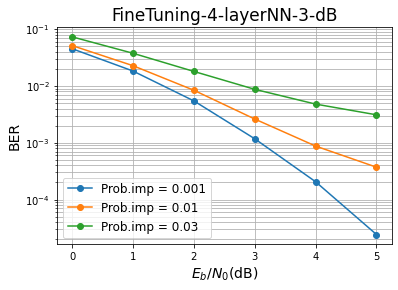

In [25]:
legend = []
# plt.plot(10*np.log10(1/(2*sigmas_map**2))-10*np.log10(k/N) , nb_errors_map/nb_bits_map, '-o')
# legend.append('MAP')

for p in range(0,len(impulse_probs)):
    # plt.plot(10*np.log10(1/(2*noise_sigmas**2)) -10*np.log10(k/N)-10*np.log10(np.log2(4)), BER[p], '-o')
    plt.plot(test_SNR_dB, BER[p], '-o')
    if (impulse_probs[p] == -1): legend.append("AWGN")
    else : legend.append("Prob.imp = "+ str(impulse_probs[p]))
    
plt.legend(legend, loc = 0, fontsize=12)
plt.yscale('log')
plt.ylabel('BER', fontsize=14) 
plt.xlabel('$E_b/N_0$(dB)', fontsize=14)
plt.title("FineTuning-4-layerNN-3-dB", fontsize=17)
# plt.grid(True, which="both")
plt.grid(True, which="both")
plt.rcParams['figure.figsize'] = (11, 7)
plt.show()
    
# Eb/N0 = 10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N) 
# Eb/N0 = symbols 能量 / 多少 bits = 平均每個 bits 的能量 
# BER : nb_errors/nb_bits